# Auxiliar Libraries

---
It's necessary restar runtime!!


In [9]:
%cd /content/drive/MyDrive/DS/Infectious_diseases_Colombia_project
!pip install -U scikit-learn
!pip install pyflux
!pip install autoimpute
!pip install fbprophet

/content/drive/.shortcut-targets-by-id/120/DS/Infectious_diseases_Colombia_project


# **Infectious Diseases and climatic and socioeconomic variables in Colombia**

In [7]:
### Load relevant packages
import  pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
import fbprophet
from fbprophet import Prophet

# autoimpute imports - utilities & visuals
from autoimpute.utils import md_pattern, proportions
from autoimpute.visuals import plot_md_locations, plot_md_percent
from autoimpute.visuals import plot_imp_dists, plot_imp_boxplots
from autoimpute.visuals import plot_imp_swarm, plot_imp_strip
from autoimpute.visuals import plot_imp_scatter

# autoimpute imports - imputations & analysis
from autoimpute.imputations import MultipleImputer
from autoimpute.analysis import MiLinearRegression



In [10]:
#reading csv file from previous diseases data integration
data = pd.read_csv('data/integrated.csv', encoding='utf-8-sig')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning:

Columns (43,46,47) have mixed types.Specify dtype option on import or set low_memory=False.



In [11]:
data.columns

Index(['Unnamed: 0', 'COD_EVE', 'FEC_NOT', 'SEMANA', 'ANO', 'COD_PRE',
       'COD_SUB', 'EDAD', 'UNI_MED', 'SEXO', 'COD_PAIS_O', 'COD_DPTO_O',
       'COD_MUN_O', 'AREA', 'OCUPACION', 'TIP_SS', 'PER_ETN', 'GP_DISCAPA',
       'GP_DESPLAZ', 'GP_MIGRANT', 'GP_CARCELA', 'GP_GESTAN', 'GP_INDIGEN',
       'GP_POBICFB', 'GP_MAD_COM', 'GP_DESMOVI', 'GP_PSIQUIA', 'GP_VIC_VIO',
       'GP_OTROS', 'COD_DPTO_R', 'COD_MUN_R', 'FEC_CON', 'INI_SIN', 'TIP_CAS',
       'PAC_HOS', 'FEC_HOS', 'CON_FIN', 'FEC_DEF', 'AJUSTE', 'FM_FUERZA',
       'confirmados', 'est_f_caso', 'Evento', 'nom_est_f_caso',
       'Departamento_residencia', 'Municipio_residencia',
       'Departamento_ocurrencia', 'Municipio_ocurrencia', 'Date', 'Date_month',
       'Poverty_rate', 'Indigence_rate', 'MES', 'tavg', 'prcp'],
      dtype='object')

Some values are represented as months and days, so we will fix these values to compare Maracuyas to Maracuyas.

In [12]:
data.loc[data['UNI_MED'] == 1,  'FIXED_EDAD'] = data['EDAD']
data.loc[data['UNI_MED'] == 2,  'FIXED_EDAD'] = data['EDAD'] / 12
data = data[(data['UNI_MED'] != 3) & (data['UNI_MED'] != 4) & (data['UNI_MED'] != 5) & (data['UNI_MED'] != 0)]


In [13]:
data['FIXED_EDAD'] = data['FIXED_EDAD'].apply(lambda x: round(x, 1)) 

There are some columns that are not necessary for the analysis, so we dropped these columns to work with specific data.

In [14]:
list_filter = ['Unnamed: 0', 'FEC_NOT', 'SEMANA', 'ANO', 'COD_PRE', 'COD_SUB', 'EDAD', 'UNI_MED', 'COD_PAIS_O',\
               'COD_DPTO_O', 'COD_MUN_O', 'PER_ETN', 'GP_DISCAPA',	'GP_DESPLAZ',	'GP_MIGRANT',	'GP_CARCELA',	'GP_GESTAN',\
               'GP_INDIGEN',	'GP_POBICFB',	'GP_MAD_COM',	'GP_DESMOVI',	'GP_PSIQUIA',	'GP_VIC_VIO',	'GP_OTROS',\
               'COD_DPTO_R',	'COD_MUN_R',	'FEC_CON',	'INI_SIN', 'TIP_CAS', 'PAC_HOS', 'FEC_HOS', 'CON_FIN', 'FEC_DEF', 'AJUSTE',\
               'FM_FUERZA', 'confirmados', 'est_f_caso', 'nom_est_f_caso', 'Departamento_ocurrencia', 'Municipio_ocurrencia', 'MES', 'Date_month']

data_filter = data.drop(list_filter, axis = 1)

**Concepts of MCAR, MAR and MNAR**

Our variables of analysis are proverty rate, indigence rate, temperature (tavg) and prcp (precipitation), these columns have a lot of null values, so we must deal with it null values, to impute these values we will analyze some interesting technics to impute. Classified missing data problems into three categories. In his theory every data point has some likelihood of being missing. The process that governs these probabilities is called the missing data mechanism or response mechanism. The model for the process is called the missing data model or response model Rubin (1976).

If the probability of being missing is the same for all cases, then the data are said to be missing completely at random (MCAR). This effectively implies that causes of the missing data are unrelated to the data. We may consequently ignore many of the complexities that arise because data are missing, apart from the obvious loss of information. If the probability of being missing is the same only within groups defined by the observed data, then the data are missing at random (MAR). MAR is a much broader class than MCAR. 

If neither MCAR nor MAR holds, then we speak of missing not at random (MNAR). In the literature one can also find the term NMAR (not missing at random) for the same concept. MNAR means that the probability of being missing varies for reasons that are unknown to us. For example, the weighing scale mechanism may wear out over time, producing more missing data as time progresses, but we may fail to note this. If the heavier objects are measured later in time, then we obtain a distribution of the measurements that will be distorted. MNAR includes the possibility that the scale produces more missing values for the heavier objects (as above), a situation that might be difficult to recognize and handle. 



1976. “Inference and Missing Data.” Biometrika 63 (3): 581–90.


In [15]:
data_filter.isnull().sum()

COD_EVE                        0
SEXO                           0
AREA                           0
OCUPACION                      0
TIP_SS                         0
Evento                         0
Departamento_residencia        0
Municipio_residencia           0
Date                           0
Poverty_rate               80199
Indigence_rate             80199
tavg                        7817
prcp                       31367
FIXED_EDAD                     0
dtype: int64

In [16]:
data_filter['Date'] = pd.to_datetime(data_filter['Date'])

# Data imputation

As there are null values ​​in the hypothesis variables, the next step is to try to impute these data, for the variables of temperature, precipitation, poverty rate and indigence rate, to analyze the imputation, we can suggest that the variance after the imputation will not change, therefore the covariance and correlation must be invariant, in this case we implement 3 imputation methods as shown in the following graph.

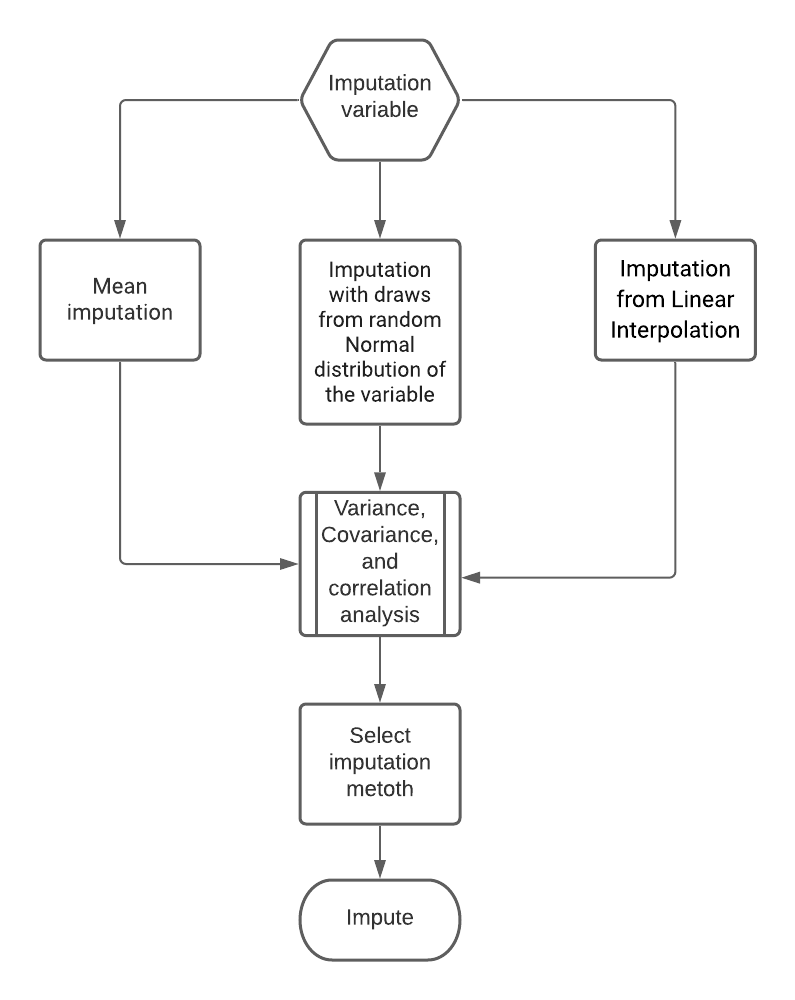

Assuming that our data is of type MAR (Missing at Random) we can infer that the objective of the imputation is to preserve the structure of the data, not to guess which values ​​are correct and in essence we will never know what the true values ​​we are looking for are, for Therefore, we want to preserve the covariance and correlation between the characteristics after imputation takes place. If we preserve the structure of the data, we can more safely assume that our allegations are plausible. For all imputation methods, we run three different best tests and we average all three results to take the best behavior of the data, the next char explains how it works.

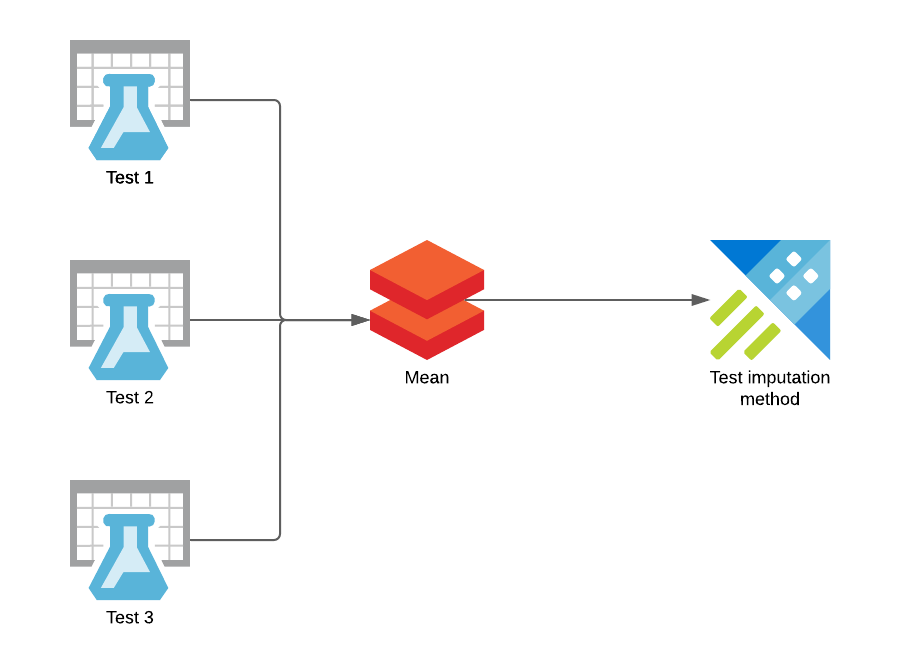

**Note**

This analysis was made to Cali, but the same behavior is present for other cities and the general data.

In [17]:
data_imputation = data_filter.copy()

In [18]:


def imputation_method(variable, strategy, n, multiple = None):

  if multiple is None:
    temp = data_imputation[[variable]].copy()
      # create the mean imputer
    mi_mean_mcar = MultipleImputer(
        strategy=strategy, n = n, return_list=True, seed=101
    )

    # print the mean imputer to console
    print(mi_mean_mcar)

    # perform mean imputation procedure
    imp_mean_mcar = mi_mean_mcar.fit_transform(temp)
  else:
    cat_features = data_imputation.select_dtypes(include = ["object", "category"]).columns
    cat_features = cat_features[:2]
    one_hot = pd.get_dummies(data_imputation[cat_features])
    data_transform = pd.concat([data_imputation, one_hot], axis = 1)
    data_transform = data_transform.select_dtypes(np.number).drop(['COD_EVE', 'tavg', 'prcp', 'Indigence_rate'], axis=1)
    temp = data_transform


    # create the mean imputer
    mi_mean_mcar = MultipleImputer(
        strategy=strategy, n = n, return_list=True, seed=101, predictors ={
            'Poverty_rate': ['AREA', 'OCUPACION', 'FIXED_EDAD', 'SEXO_F', 'SEXO_I',
       'SEXO_M', 'TIP_SS_C', 'TIP_SS_E', 'TIP_SS_I', 'TIP_SS_N', 'TIP_SS_P',
       'TIP_SS_S']
        }
    )

    # print the mean imputer to console
    print(mi_mean_mcar)

    # perform mean imputation procedure
    imp_mean_mcar = mi_mean_mcar.fit_transform(temp)

  list_data = []
  for i in range(len(imp_mean_mcar)):
    temp = imp_mean_mcar[i][1]
    temp = temp.rename(columns={variable: 'Values'})
    temp['Imputed'] = variable +"_"+ str(i)+"_"+strategy
    temp['index'] = temp.index
    list_data.append(temp)

  temp2 = data_imputation[[variable]].copy()
  temp2['index'] = temp2.index
  imputed_rows = list(temp2[temp2[variable].isnull()]['index'])

  temp2 = temp2.rename(columns = {variable: 'Values'})
  temp2['Imputed'] = 'Original'
  temp3 = temp2.append(list_data[0])
  temp4 = temp3.append(list_data[1])
  total = temp4.append(list_data[2])

  total['vale_imputed'] = total['index'].apply(lambda x: 'Yes' if x in imputed_rows else 'No')
  return total

In [19]:

def tables_temp(city):
  table1 = table_result_temp[table_result_temp['Imputed'] == 'Original'] 
  table2 = table_result_temp[table_result_temp['Imputed'] == variable +"_"+ str(0)+"_"+strategy] 
  table3 = table_result_temp[table_result_temp['Imputed'] == variable +"_"+ str(1)+"_"+strategy] 
  table4 = table_result_temp[table_result_temp['Imputed'] == variable +"_"+ str(2)+"_"+strategy] 


  prom_imputed1 = table1.merge(table2, on='index',how = 'left',suffixes=('','_1'))
  prom_imputed2 = prom_imputed1.merge(table3, on='index',how = 'left',suffixes=('','_2'))
  prom_impute_total = prom_imputed2.merge(table4, on='index',how = 'left',suffixes=('','_3'))
  prom_impute_total['prom_value'] = (prom_impute_total['Values_1'] + prom_impute_total['Values_2'] + prom_impute_total['Values_3'])/3

  time_series = data_imputation.copy()
  time_series['index'] = time_series.index
  time_series_t = time_series.merge(prom_impute_total[['prom_value','index','vale_imputed']], on='index', how='left')
  if city is not None:
    time_series_t = time_series_t[time_series_t['Municipio_residencia'] == city]

  part_1 = time_series_t[['tavg']].copy()
  part_1['vale_imputed'] = 'No'
  part_1['Category'] = 'Original'
  part_1 = part_1.rename(columns={'tavg':'Values'})
  part_2 = time_series_t[['prom_value', 'vale_imputed']].copy()
  part_2['Category'] = 'Imputed'
  part_2 = part_2.rename(columns={'prom_value':'Values'})
  part_tot = part_1.append(part_2)

  return part_tot, time_series_t

**Temperatura**



The first stage to analyze the time series of temperature is to see how it behaves over time.

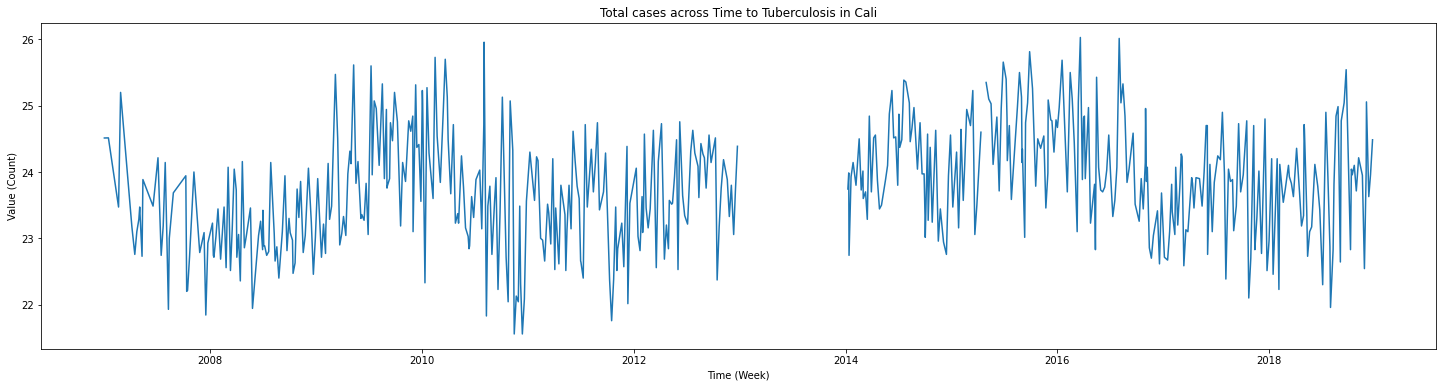

In [20]:
cali_data = data_imputation[data_imputation['Municipio_residencia'] == 'CALI']
plot_time_series_temp = cali_data.groupby('Date')['tavg'].mean().reset_index(name= 'mean')

fig, ax = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='mean', data=plot_time_series_temp, ax =ax)
ax.set_title('Total cases across Time to Tuberculosis in Cali')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time (Week)')
plt.show()

As can be seen in the graph, there are temporary jumps, so it is necessary to do the imputation process. In this case, we use Autoimpute to compare the most popular imputation methods. In the next graph, we can see all numeric variables present in the data as well all the null values that the data has.

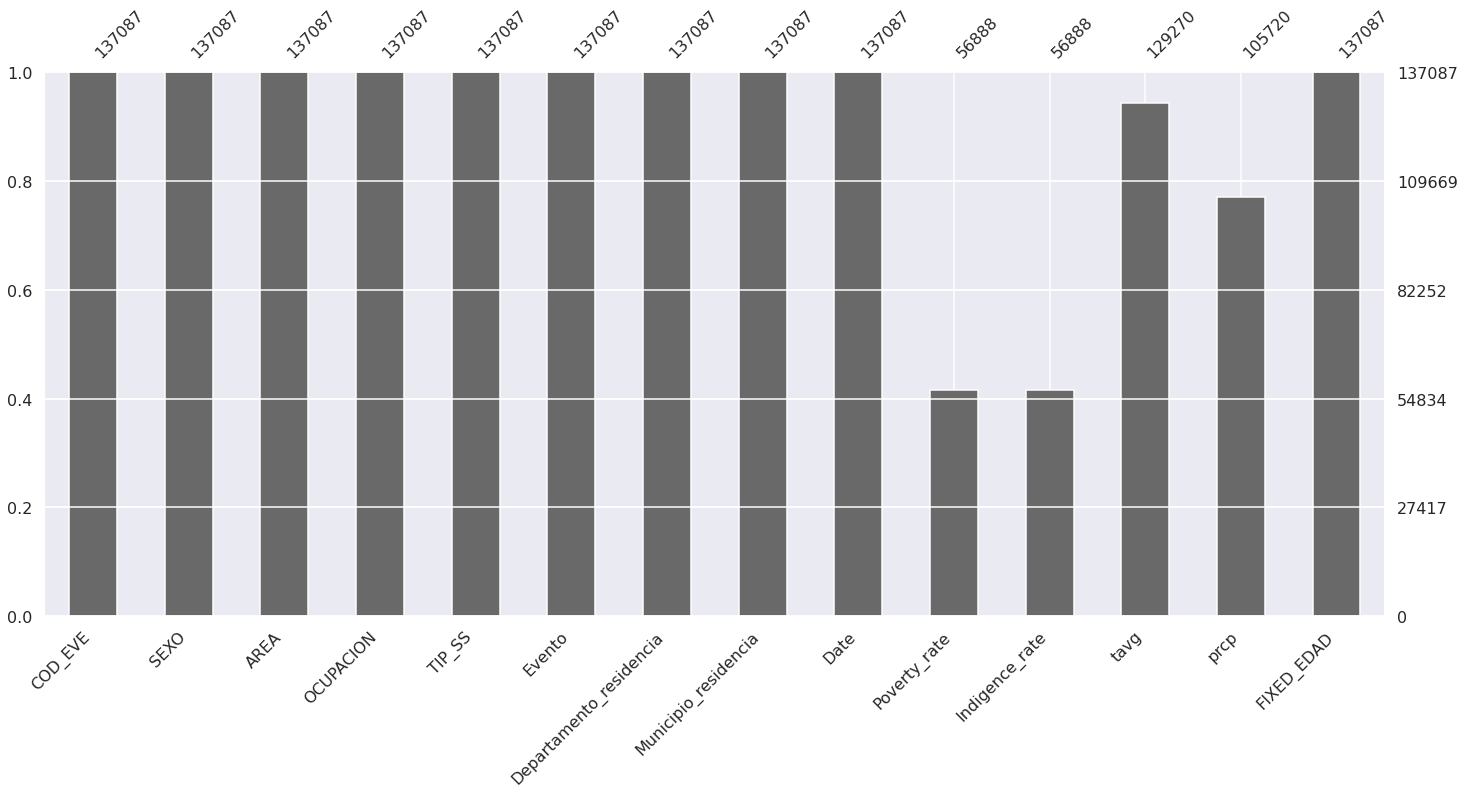

In [21]:

plot_md_percent(data_imputation)

In the next graph, we see how the null values are distributed in the data set.

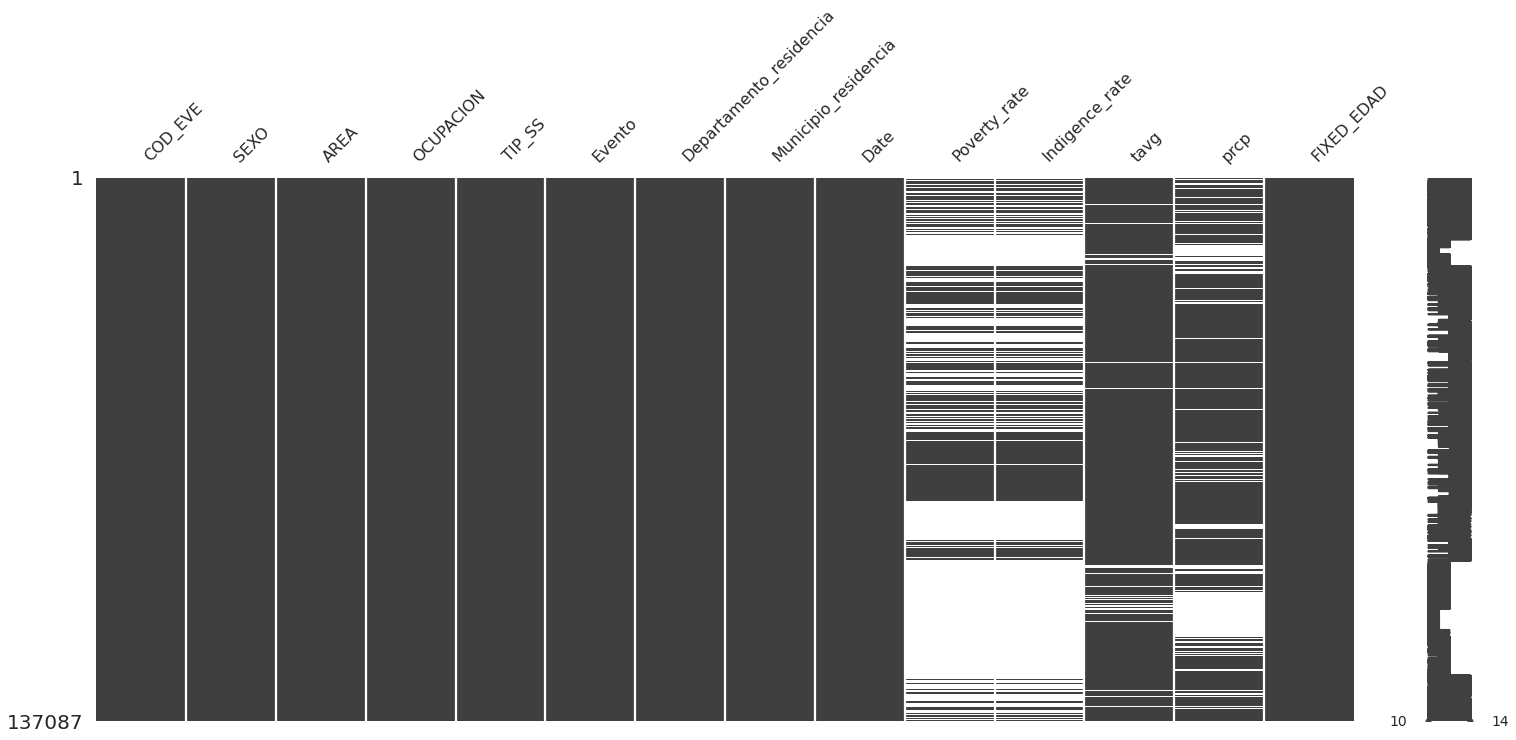

In [22]:
plot_md_locations(data_imputation)

***Mean Imputation***

The first imputation that we could analyze is the mean, in the next step we will see how this imputation affects the data.

> Bloque con sangría

> Bloque con sangría

> Bloque con sangría

> Bloque con sangría









In [23]:
variable = "tavg"
strategy = "mean"
city = 'CALI'
table_result_temp = imputation_method(variable, strategy, n = 3)
part_tot, time_series_t = tables_temp(city)

MultipleImputer(n=3, return_list=True, seed=101, strategy='mean')


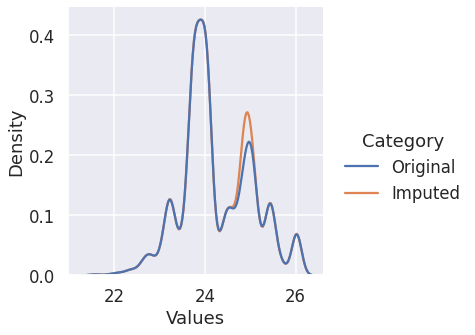

In [24]:
sns.displot(part_tot, x="Values", hue="Category", kind="kde")

How we can see here the mean imputation does not affect the distribution of the data, because in essence, we assume that the null values are the same and invariant on time. The next two graphs represent this behaviour.

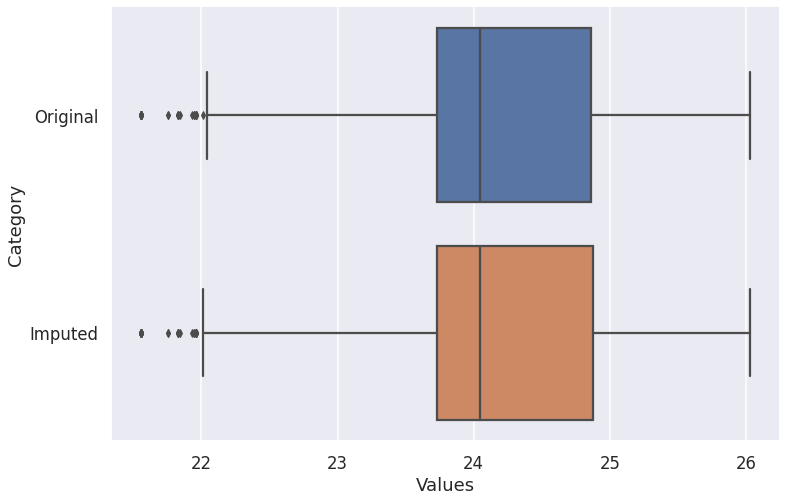

In [25]:
ax = sns.boxplot(x="Values", y="Category", data=part_tot)

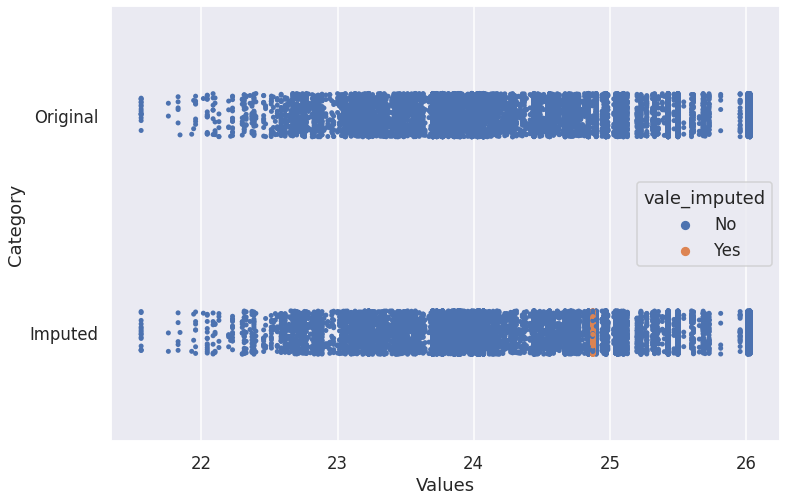

In [26]:
sns.stripplot(x='Values', y='Category', data=part_tot, hue='vale_imputed', jitter=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.



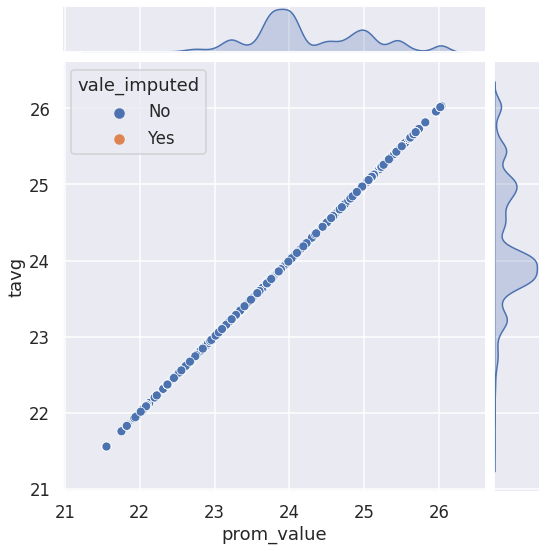

In [27]:

ax = sns.jointplot(data=time_series_t, x="prom_value", y="tavg", hue='vale_imputed', space=0.2, hue_order=['No', 'Yes'], ratio=8,  height=8)

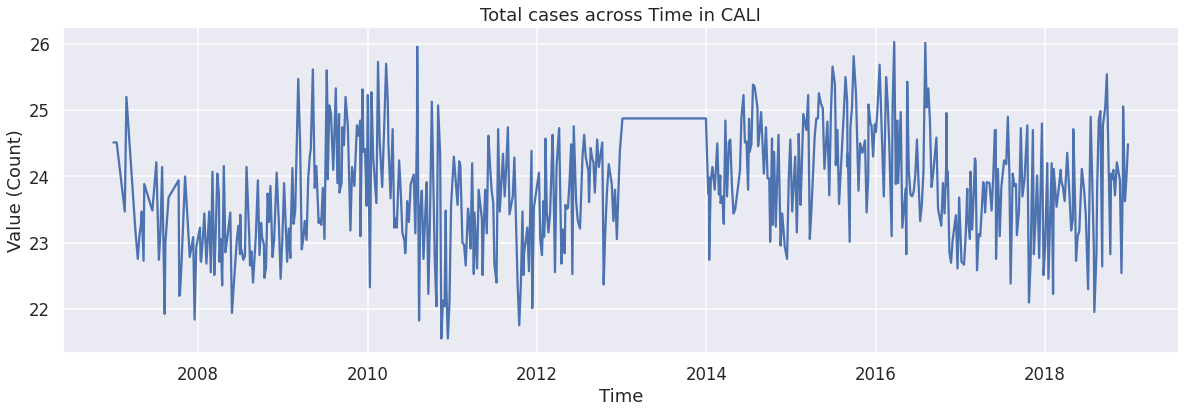

In [28]:

plot_time_series_temp = time_series_t.groupby('Date')['prom_value'].mean().reset_index(name= 'mean')
fig, ax1 = plt.subplots(figsize=(20,6))
ax = sns.lineplot(x='Date',y='mean', data=plot_time_series_temp)
ax.set_title('Total cases across Time in {}'.format(city))
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

In [29]:

temp = time_series_t[['prom_value', variable]].copy()
# create the mean imputer
cov = temp.cov()
corr = temp.corr()
cov_corr_df = pd.concat([cov, corr], axis=1)
cov_corr_df.columns = columns=["cov_prom_value", "cov_"+variable, "corr_prom_value", "corr_"+variable]

temp['diff'] = (temp[variable] - temp['prom_value'])**2 
error = np.sqrt(temp['diff'].sum()/len(temp))

print("El error estandar de la imputación es:", error)
print("La varianza de la serie original es:", temp.var().to_dict()[variable])
print("La varianza de la serie imputada es:", temp.var().to_dict()['prom_value'])
print("La differencia de varianza es:",  temp.var().to_dict()[variable] - temp.var().to_dict()['prom_value'])

cov_corr_df

El error estandar de la imputación es: 1.7295609500258714e-15
La varianza de la serie original es: 0.6244585429971377
La varianza de la serie imputada es: 0.6168574637932313
La differencia de varianza es: 0.007601079203906402


cov_prom_value  cov_tavg  corr_prom_value  corr_tavg
prom_value        0.616857  0.624459              1.0        1.0
tavg              0.624459  0.624459              1.0        1.0

As we can see above, the variance and the correlation don't change, but the covariance is affected on lesser extended, but we skewed the data, we can not assume that the temperature is the same for all the days imputed, the temperature change, so we discard the imputation means for all missing variables.

**Imputatiion with draws from random Normal distribution of the variable**

As the tittle assume, we impute according to the normal distribution of the variable, we assume that the distribution contains all the behaviors present in the data, so we could make an imputation method to take the distribution and create random numbers according to the distribution and then impute it.

In [30]:
variable = "tavg"
strategy = "norm"
city = 'CALI'
table_result_temp = imputation_method(variable, strategy, n = 3)
part_tot, time_series_t = tables_temp(city)

MultipleImputer(n=3, return_list=True, seed=101, strategy='norm')


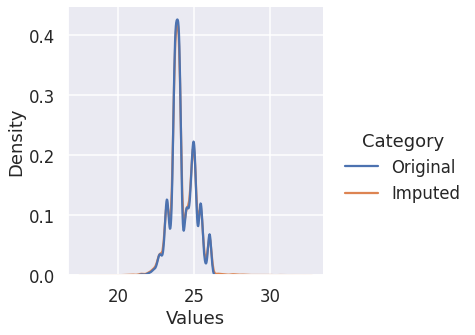

In [31]:
sns.displot(part_tot, x="Values", hue="Category", kind="kde")

As we can see here, the distribution is the same, so could assume that the data are equally distributed according to the distribution variable.

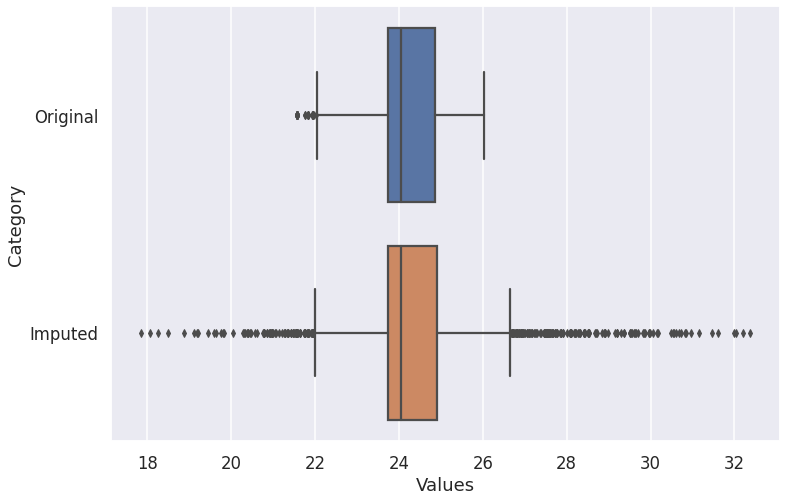

In [32]:
ax = sns.boxplot(x="Values", y="Category", data=part_tot)

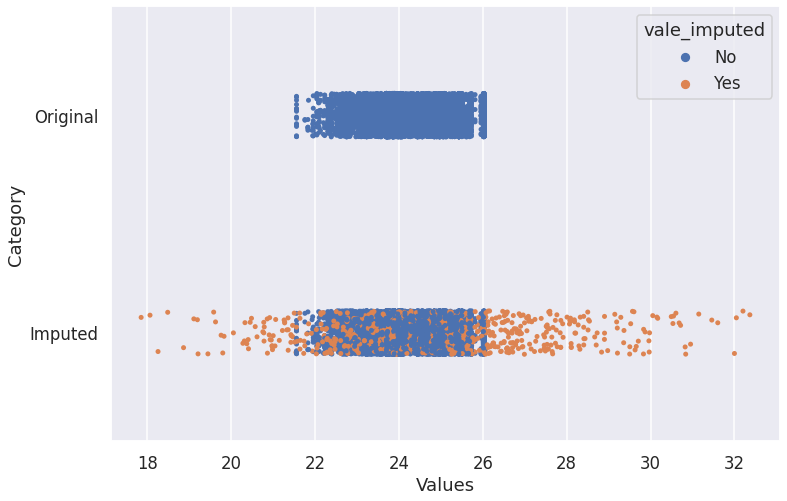

In [33]:
sns.stripplot(x='Values', y='Category', data=part_tot, hue='vale_imputed', jitter=True)

In the charts above, we can see that are some outliers values, because the imputation does not have a maximum or minimum limitation value.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.



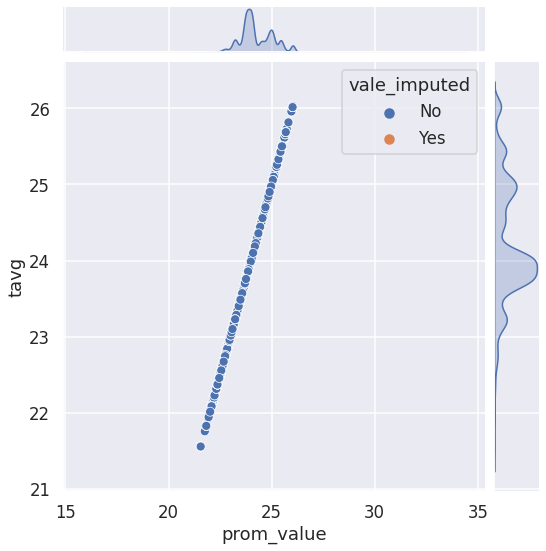

In [34]:
ax = sns.jointplot(data=time_series_t, x="prom_value", y="tavg", hue='vale_imputed', space=0.2, hue_order=['No', 'Yes'], ratio=8,  height=8)

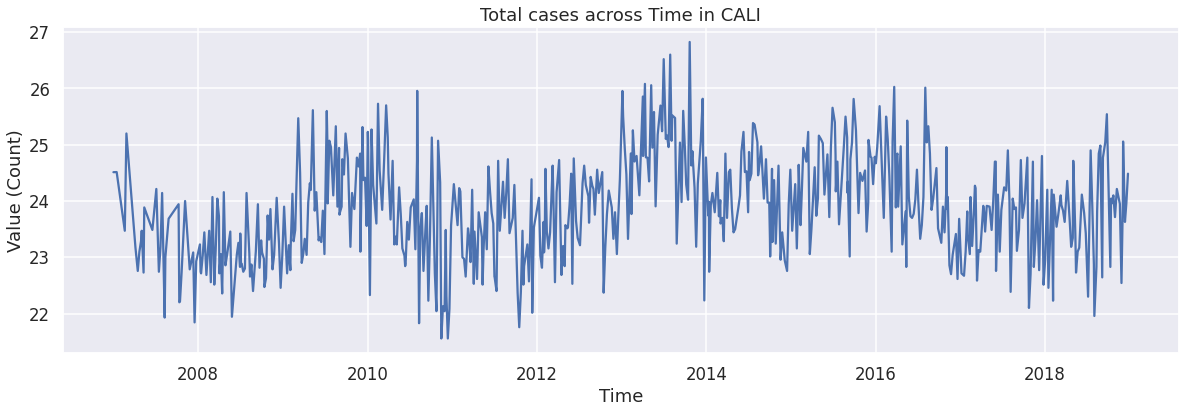

In [35]:

plot_time_series_temp = time_series_t.groupby('Date')['prom_value'].mean().reset_index(name= 'mean')
fig, ax1 = plt.subplots(figsize=(20,6))
ax = sns.lineplot(x='Date',y='mean', data=plot_time_series_temp)
ax.set_title('Total cases across Time in {}'.format(city))
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

In [36]:

temp = time_series_t[['prom_value', variable]].copy()
# create the mean imputer
cov = temp.cov()
corr = temp.corr()
cov_corr_df = pd.concat([cov, corr], axis=1)
cov_corr_df.columns = columns=["cov_prom_value", "cov_"+variable, "corr_prom_value", "corr_"+variable]

temp['diff'] = (temp[variable] - temp['prom_value'])**2 
error = np.sqrt(temp['diff'].sum()/len(temp))

print("El error estandar de la imputación es:", error)
print("La varianza de la serie original es:", temp.var().to_dict()[variable])
print("La varianza de la serie imputada es:", temp.var().to_dict()['prom_value'])
print("La differencia de varianza es:",  temp.var().to_dict()[variable] - temp.var().to_dict()['prom_value'])


cov_corr_df

El error estandar de la imputación es: 1.7295609500258714e-15
La varianza de la serie original es: 0.6244585429971377
La varianza de la serie imputada es: 0.8214567078959547
La differencia de varianza es: -0.19699816489881705


cov_prom_value  cov_tavg  corr_prom_value  corr_tavg
prom_value        0.821457  0.624459              1.0        1.0
tavg              0.624459  0.624459              1.0        1.0

As we can see above, the correlation does not change, but the covariance and the variance change a lot, ins the same way the graph that shows the behavior of the data across the time seems more real between the years 2013 and 2014 if we compare it to the imputation mean, but the variance is no the best, we could implement one last imputation method, the linear interpolation.

**Imputation from Linear Interpolation**

The linear interpolation assumes that the data could be represented by a linear equation, and there are not no-linear relationships with other variables exogenous of the data. Let's implements this on the data.

In [37]:
variable = "tavg"
strategy = "interpolate"
city = 'CALI'
table_result_temp = imputation_method(variable, strategy, n = 3)
part_tot, time_series_t = tables_temp(city)

MultipleImputer(n=3, return_list=True, seed=101, strategy='interpolate')


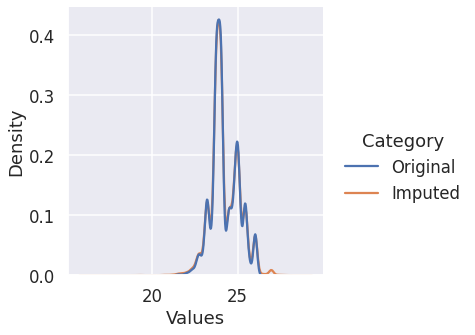

In [38]:
sns.displot(part_tot, x="Values", hue="Category", kind="kde")

As we can see here, the distribution is the same with some differences for values above to 26, so could assume that the data are equally distributed according to the distribution variable, the next graphs demonstrate it.

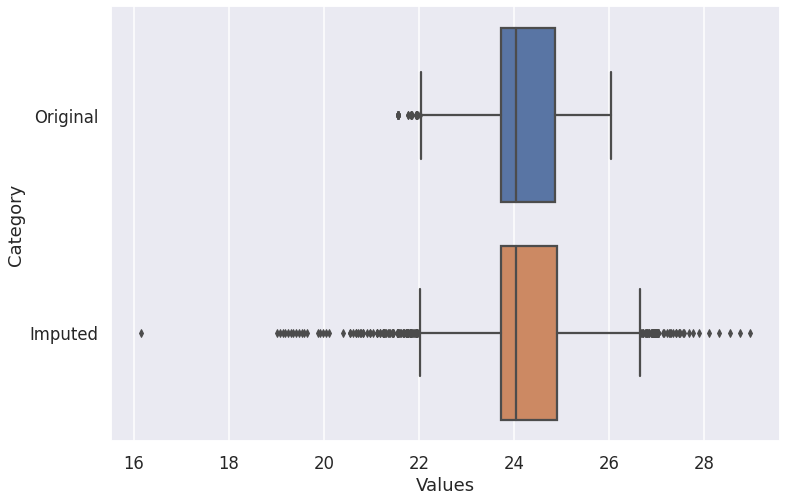

In [39]:
ax = sns.boxplot(x="Values", y="Category", data=part_tot)

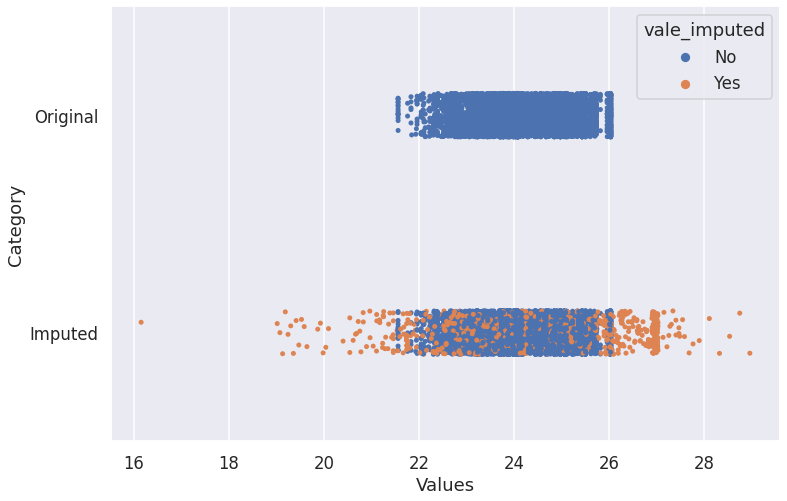

In [40]:
sns.stripplot(x='Values', y='Category', data=part_tot, hue='vale_imputed', jitter=True)

There are some outliers values, but much less if we compared it to the random imputation

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.



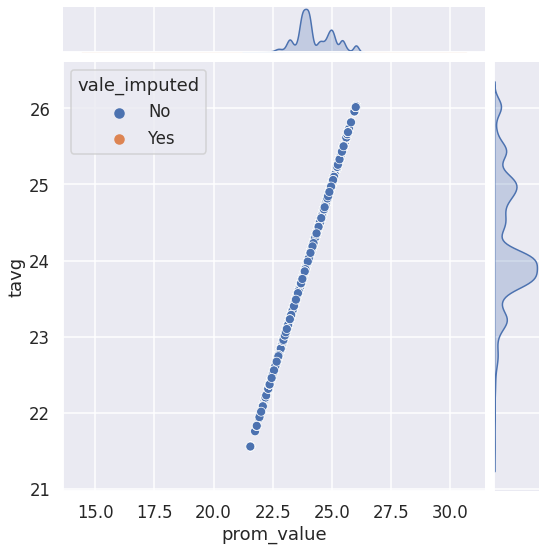

In [41]:
ax = sns.jointplot(data=time_series_t, x="prom_value", y="tavg", hue='vale_imputed', space=0.2, hue_order=['No', 'Yes'], ratio=8,  height=8)

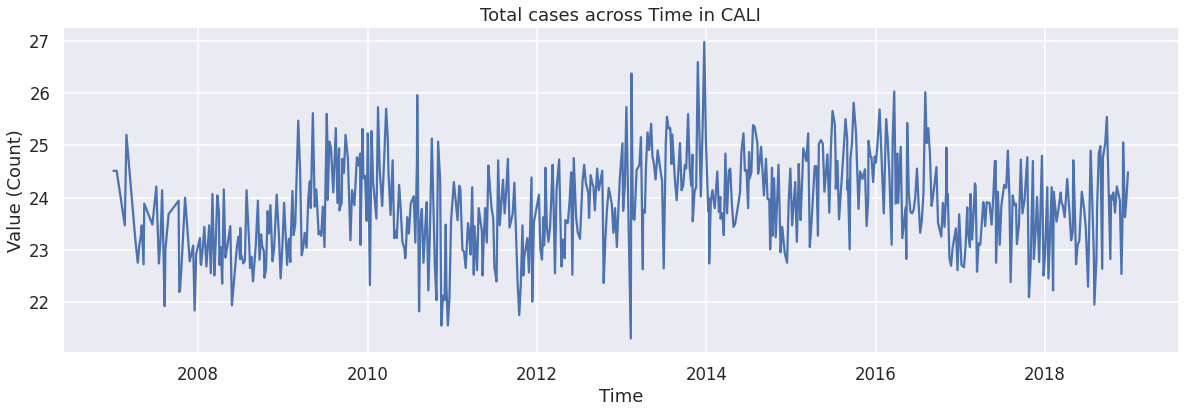

In [42]:

plot_time_series_temp = time_series_t.groupby('Date')['prom_value'].mean().reset_index(name= 'mean')
fig, ax1 = plt.subplots(figsize=(20,6))
ax = sns.lineplot(x='Date',y='mean', data=plot_time_series_temp)
ax.set_title('Total cases across Time in {}'.format(city))
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

In [43]:

temp = time_series_t[['prom_value', variable]].copy()
# create the mean imputer
cov = temp.cov()
corr = temp.corr()
cov_corr_df = pd.concat([cov, corr], axis=1)
cov_corr_df.columns = columns=["cov_prom_value", "cov_"+variable, "corr_prom_value", "corr_"+variable]

temp['diff'] = (temp[variable] - temp['prom_value'])**2 
error = np.sqrt(temp['diff'].sum()/len(temp))

print("El error estandar de la imputación es:", error)
print("La varianza de la serie original es:", temp.var().to_dict()[variable])
print("La varianza de la serie imputada es:", temp.var().to_dict()['prom_value'])
print("La differencia de varianza es:",  temp.var().to_dict()[variable] - temp.var().to_dict()['prom_value'])
cov_corr_df

El error estandar de la imputación es: 1.7295609500258714e-15
La varianza de la serie original es: 0.6244585429971377
La varianza de la serie imputada es: 0.7481808585918817
La differencia de varianza es: -0.123722315594744


cov_prom_value  cov_tavg  corr_prom_value  corr_tavg
prom_value        0.748181  0.624459              1.0        1.0
tavg              0.624459  0.624459              1.0        1.0


 We can see that the variance and the covariance are affected but if we compare with random imputation (diff_variance: -0.19699816489881705) this value is much less here, so we could use this imputation method to impute the temperature variable.

**Precipitation**

The first stage to analyze the time series of precipitation is to see how it behaves over time.

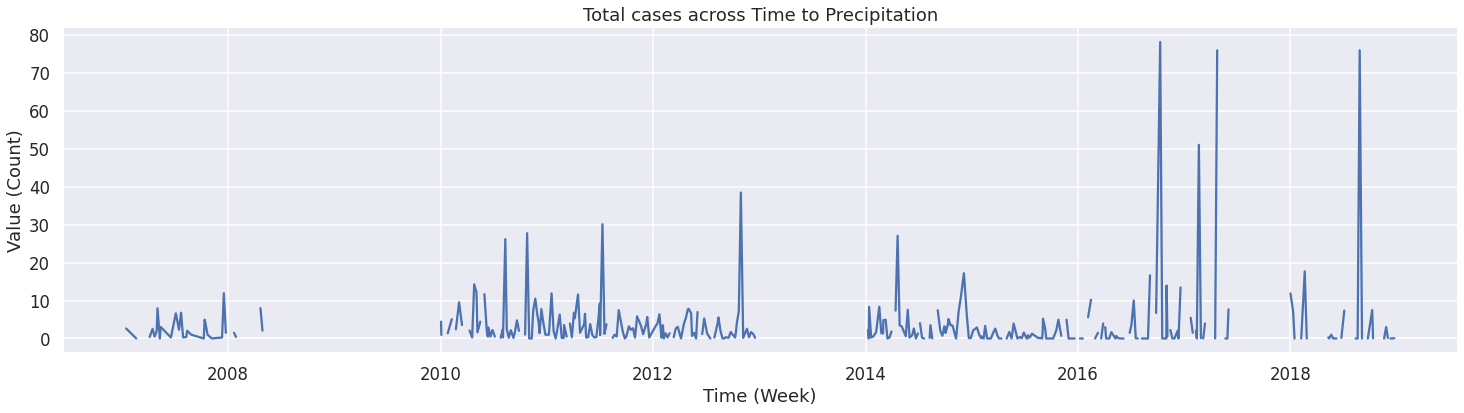

In [44]:
cali_data = data_imputation[data_imputation['Municipio_residencia'] == 'CALI']
plot_time_series_temp = cali_data.groupby('Date')['prcp'].mean().reset_index(name= 'mean')

fig, ax = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='mean', data=plot_time_series_temp, ax =ax)
ax.set_title('Total cases across Time to Precipitation')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time (Week)')
plt.show()

**Imputatiion with draws from random Normal distribution of the variable**

In [45]:
variable = "prcp"
strategy = "norm"
city = 'CALI'
table_result_temp = imputation_method(variable, strategy, n = 3)
part_tot, time_series_t = tables_temp(city)

MultipleImputer(n=3, return_list=True, seed=101, strategy='norm')


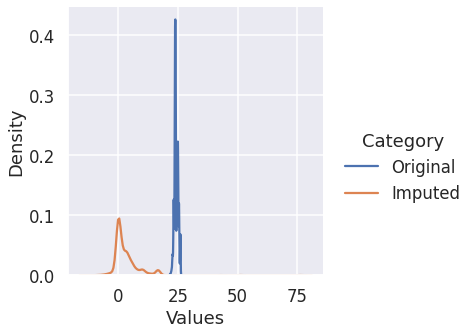

In [46]:
sns.displot(part_tot, x="Values", hue="Category", kind="kde")

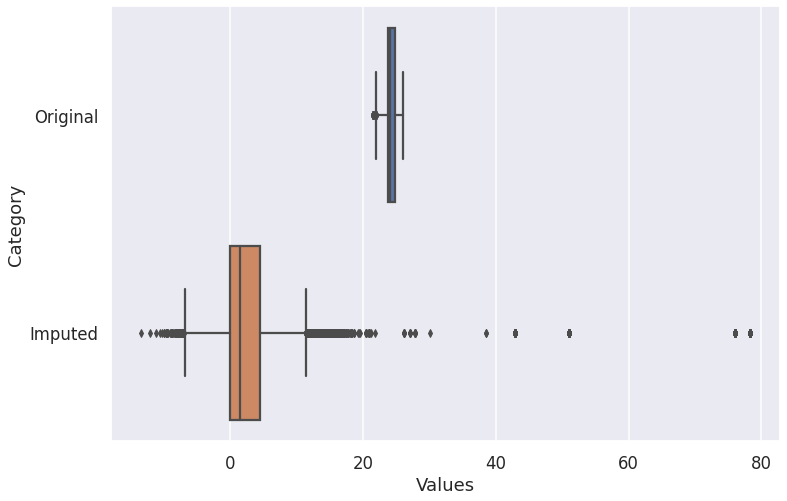

In [47]:
ax = sns.boxplot(x="Values", y="Category", data=part_tot)

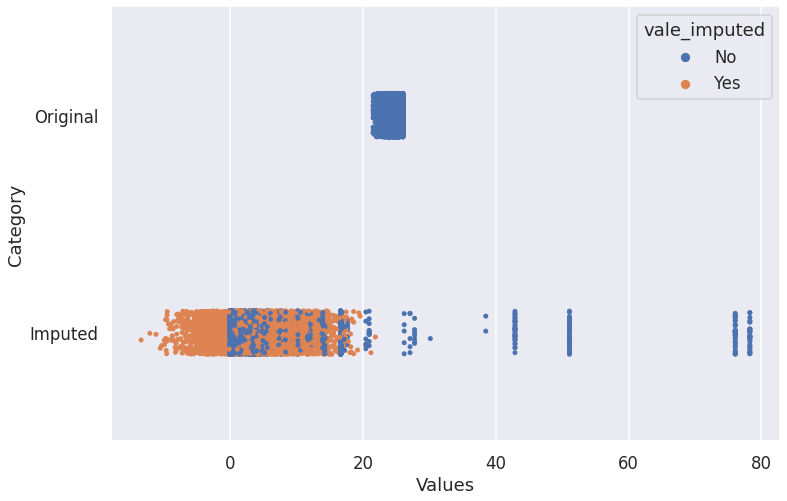

In [48]:
sns.stripplot(x='Values', y='Category', data=part_tot, hue='vale_imputed', jitter=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.



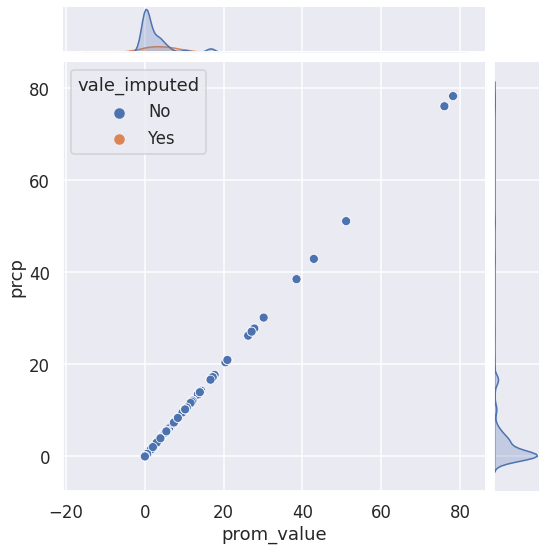

In [49]:
ax = sns.jointplot(data=time_series_t, x="prom_value", y="prcp", hue='vale_imputed', space=0.2, hue_order=['No', 'Yes'], ratio=8,  height=8)

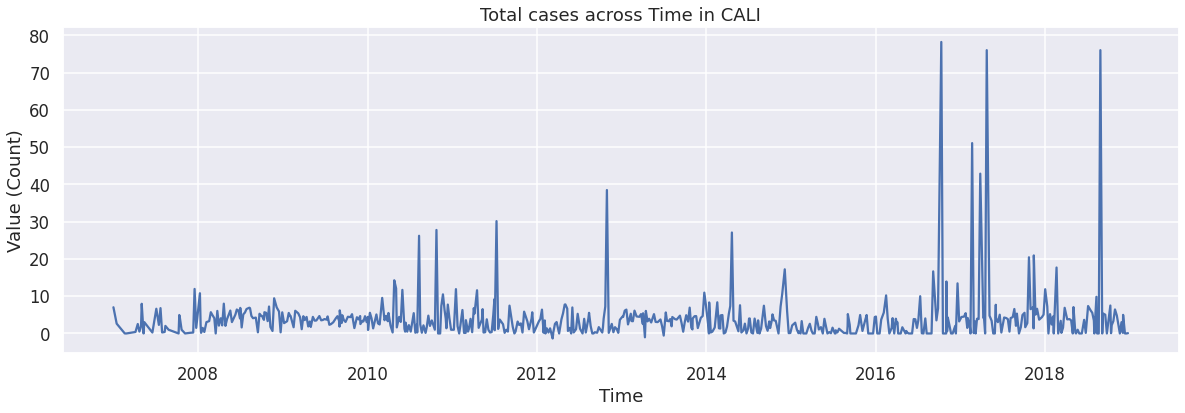

In [50]:
plot_time_series_temp = time_series_t.groupby('Date')['prom_value'].mean().reset_index(name= 'mean')
fig, ax1 = plt.subplots(figsize=(20,6))
ax = sns.lineplot(x='Date',y='mean', data=plot_time_series_temp)
ax.set_title('Total cases across Time in {}'.format(city))
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

In [51]:

temp = time_series_t[['prom_value', variable]].copy()
# create the mean imputer
cov = temp.cov()
corr = temp.corr()
cov_corr_df = pd.concat([cov, corr], axis=1)
cov_corr_df.columns = columns=["cov_prom_value", "cov_"+variable, "corr_prom_value", "corr_"+variable]

temp['diff'] = (temp[variable] - temp['prom_value'])**2 
error = np.sqrt(temp['diff'].sum()/len(temp))

print("El error estandar de la imputación es:", error)
print("La varianza de la serie original es:", temp.var().to_dict()[variable])
print("La varianza de la serie imputada es:", temp.var().to_dict()['prom_value'])
print("La differencia de varianza es:",  temp.var().to_dict()[variable] - temp.var().to_dict()['prom_value'])

cov_corr_df

El error estandar de la imputación es: 2.0747637649601666e-16
La varianza de la serie original es: 55.36896872450077
La varianza de la serie imputada es: 46.960348242748715
La differencia de varianza es: 8.408620481752052


cov_prom_value   cov_prcp  corr_prom_value  corr_prcp
prom_value       46.960348  55.368969              1.0        1.0
prcp             55.368969  55.368969              1.0        1.0

As we can see here, the variance and covariance change a lot, so this method does not meet the minimum needs which mean, small changes of variance, covariance, and correlation

**Imputation from Linear Interpolation**

In [52]:
variable = "prcp"
strategy = "interpolate"
city = 'CALI'
table_result_temp = imputation_method(variable, strategy, n = 3)
part_tot, time_series_t = tables_temp(city)

MultipleImputer(n=3, return_list=True, seed=101, strategy='interpolate')


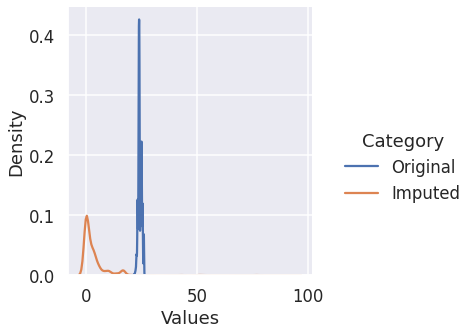

In [53]:
sns.displot(part_tot, x="Values", hue="Category", kind="kde")

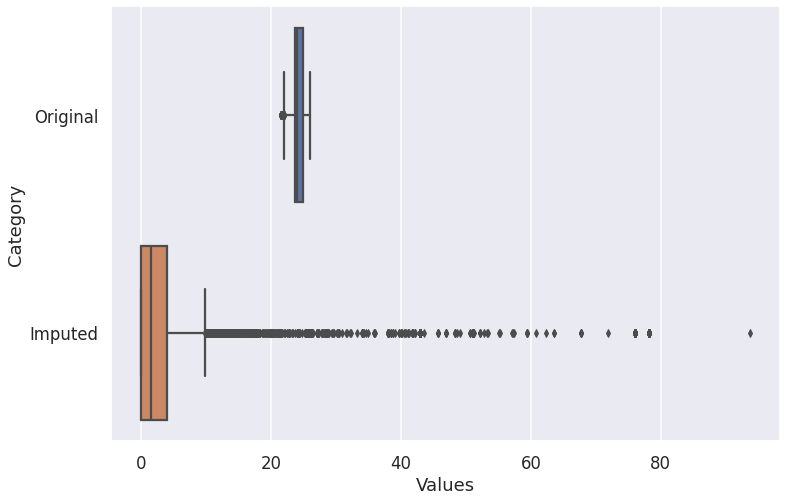

In [54]:
ax = sns.boxplot(x="Values", y="Category", data=part_tot)

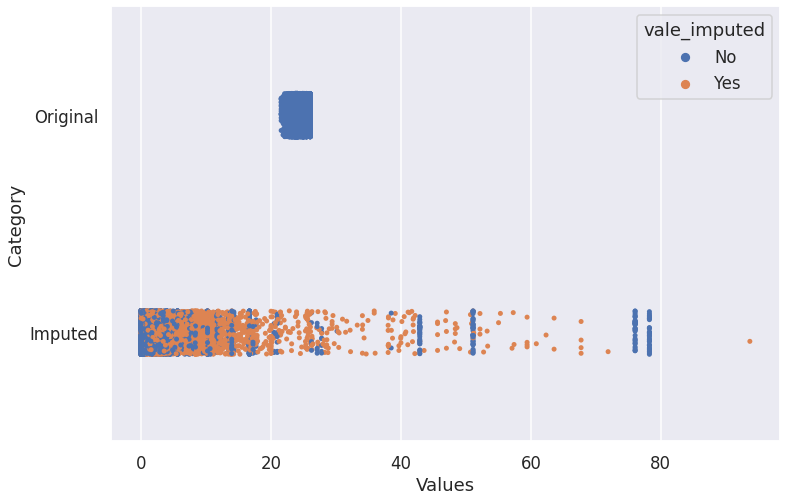

In [55]:
sns.stripplot(x='Values', y='Category', data=part_tot, hue='vale_imputed', jitter=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.



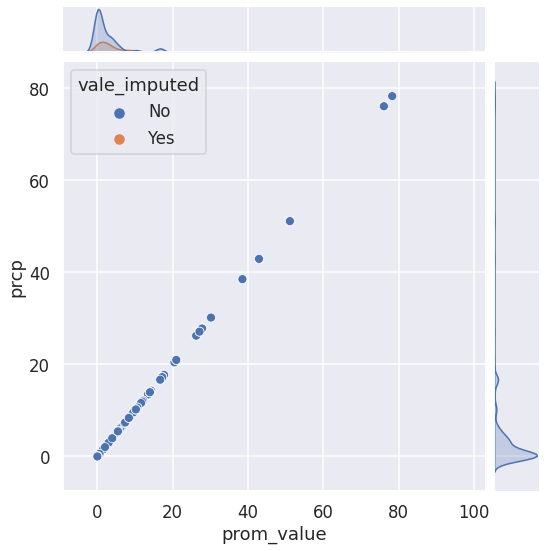

In [56]:
ax = sns.jointplot(data=time_series_t, x="prom_value", y="prcp", hue='vale_imputed', space=0.2, hue_order=['No', 'Yes'], ratio=8,  height=8)

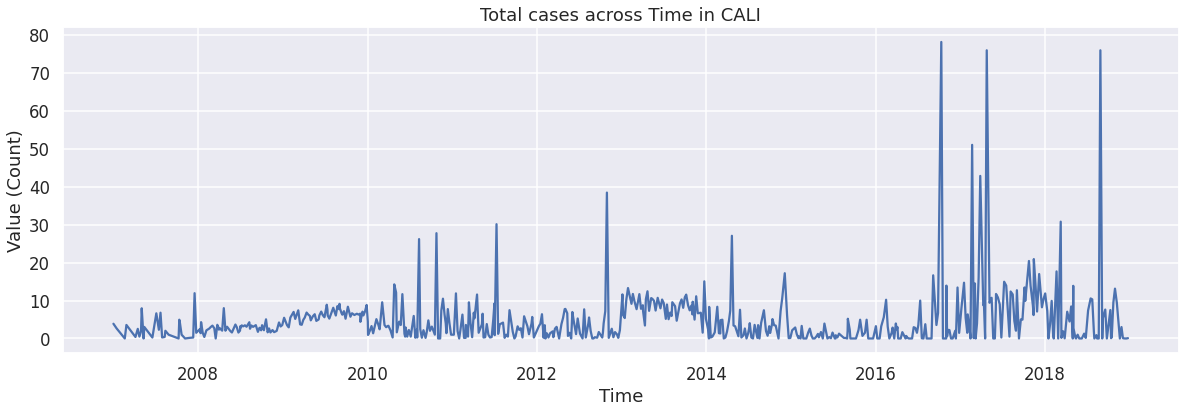

In [57]:
plot_time_series_temp = time_series_t.groupby('Date')['prom_value'].mean().reset_index(name= 'mean')
fig, ax1 = plt.subplots(figsize=(20,6))
ax = sns.lineplot(x='Date',y='mean', data=plot_time_series_temp)
ax.set_title('Total cases across Time in {}'.format(city))
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

In [58]:
temp = time_series_t[['prom_value', variable]].copy()
# create the mean imputer
cov = temp.cov()
corr = temp.corr()
cov_corr_df = pd.concat([cov, corr], axis=1)
cov_corr_df.columns = columns=["cov_prom_value", "cov_"+variable, "corr_prom_value", "corr_"+variable]

temp['diff'] = (temp[variable] - temp['prom_value'])**2 
error = np.sqrt(temp['diff'].sum()/len(temp))


print("El error estandar de la imputación es:", error)
print("La varianza de la serie original es:", temp.var().to_dict()[variable])
print("La varianza de la serie imputada es:", temp.var().to_dict()['prom_value'])
print("La differencia de varianza es:",  temp.var().to_dict()[variable] - temp.var().to_dict()['prom_value'])

cov_corr_df

El error estandar de la imputación es: 2.0747637649601666e-16
La varianza de la serie original es: 55.36896872450077
La varianza de la serie imputada es: 56.927233094492564
La differencia de varianza es: -1.5582643699917966


cov_prom_value   cov_prcp  corr_prom_value  corr_prcp
prom_value       56.927233  55.368969              1.0        1.0
prcp             55.368969  55.368969              1.0        1.0

As we can see here in this experiment, we see that the data change much less if we see the variance and covariance, if we see the charts above, we could infer that the data take come outliers values, but these outliers are reasonable in terms of values, so we could conclude that this method to impute it is near to reality.

**Poverty Rate and Indigence Rate**


Since the poverty rate can be explained by sex, occupation, or type of social security, imputation can be made taking into account these variables. In the graph next you will see how it is going on.

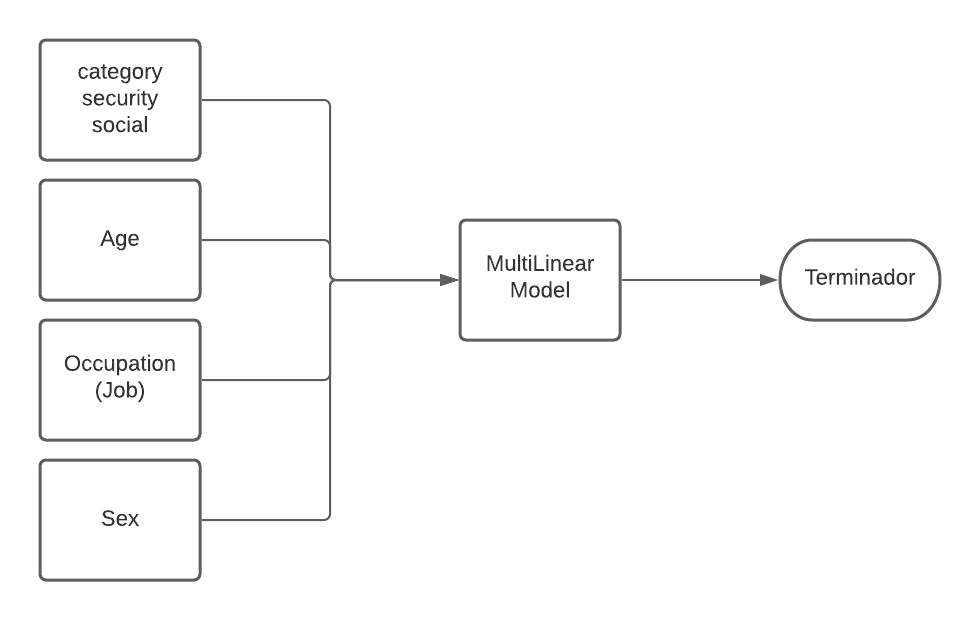

Let's transform the category variables to dummy variables with one-hot encoding

In [59]:
cat_features = data_imputation.select_dtypes(include = ["object", "category"]).columns
cat_features = cat_features[:2]
one_hot = pd.get_dummies(data_imputation[cat_features])
data_transform = pd.concat([data_imputation, one_hot], axis = 1)
data_transform = data_transform.select_dtypes(np.number).drop(['COD_EVE', 'tavg', 'prcp'], axis=1)


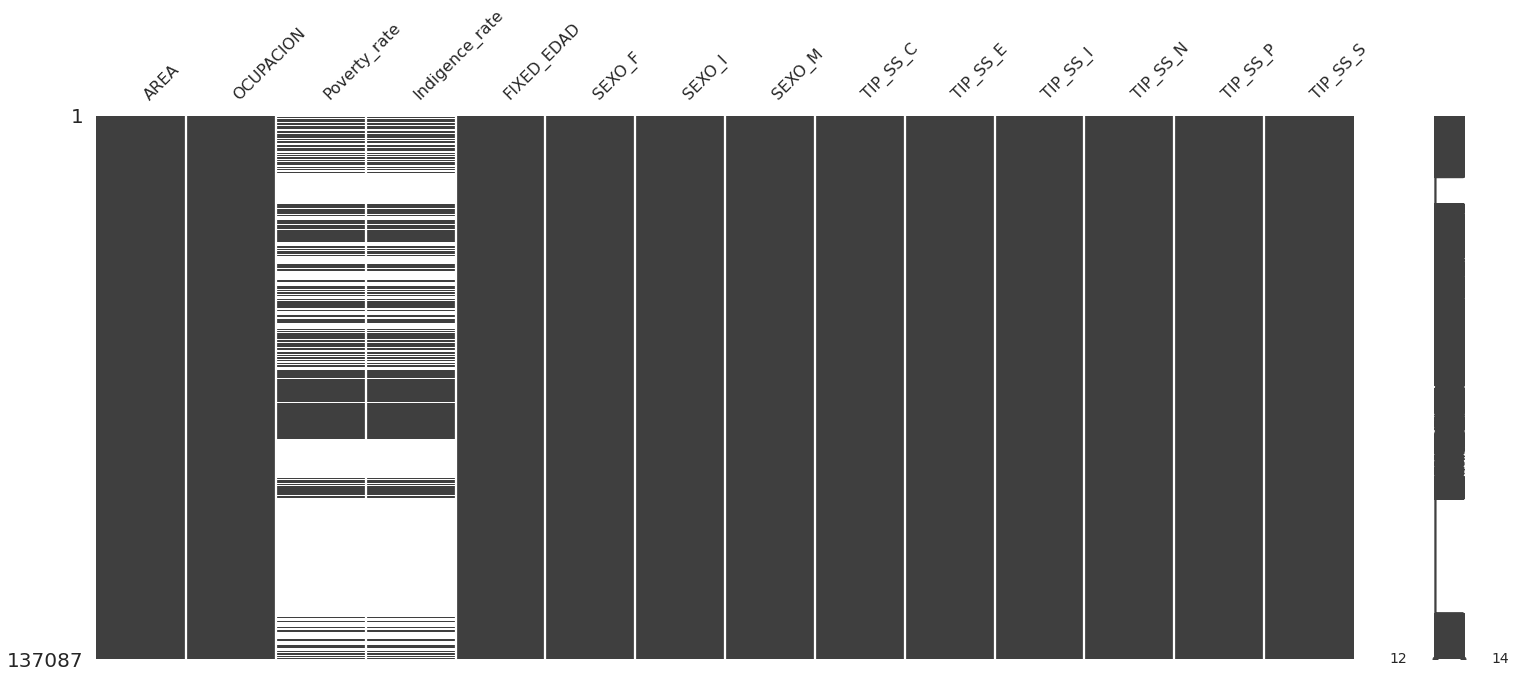

In [60]:
plot_md_locations(data_transform)

In [61]:
data_transform

AREA  OCUPACION  Poverty_rate  ...  TIP_SS_N  TIP_SS_P  TIP_SS_S
0          1       3230           NaN  ...         0         0         0
1          1       9996           NaN  ...         0         0         0
2          1       9997        0.1083  ...         0         0         0
3          1       9999        0.0954  ...         0         0         0
4          1       9997        0.0954  ...         0         0         0
...      ...        ...           ...  ...       ...       ...       ...
137720     1       9997        0.1786  ...         0         0         1
137721     1       9997        0.2177  ...         0         0         0
137722     1       9997        0.1948  ...         0         0         0
137723     1       9997        0.1948  ...         0         0         1
137724     1       9997        0.1786  ...         0         0         0

[137087 rows x 14 columns]

**Poverty**

The first task is to analyze the best before model to temperature and precipitation and see if this method of imputation works with poverty rate and indigence rate, let's to do the linear interpolation impute!!

**Imputation from Linear Interpolation**

In [62]:
variable = "Poverty_rate"
strategy = "interpolate"
city = None
table_result_temp = imputation_method(variable, strategy, n = 3)
part_tot, time_series_t = tables_temp(city)

MultipleImputer(n=3, return_list=True, seed=101, strategy='interpolate')


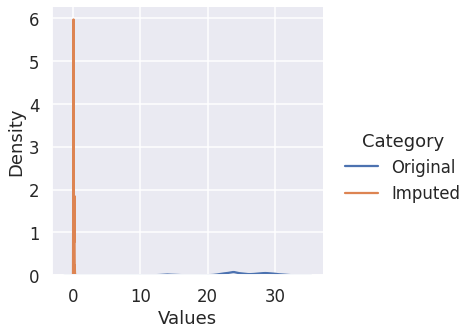

In [63]:
sns.displot(part_tot, x="Values", hue="Category", kind="kde")

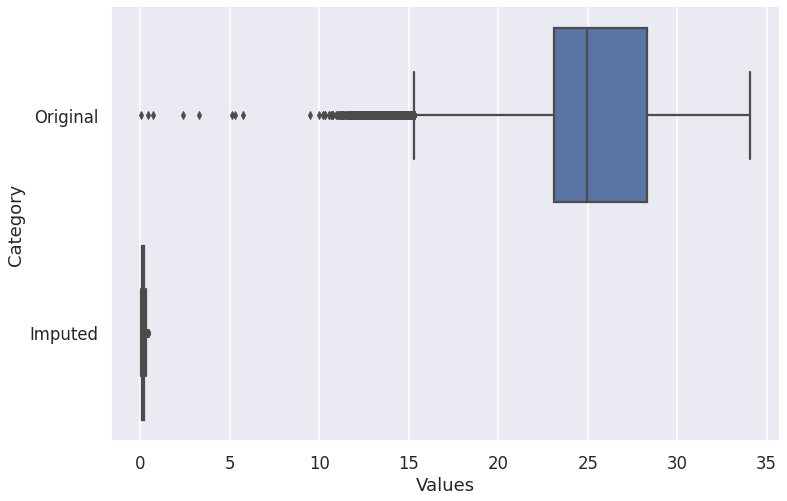

In [64]:
ax = sns.boxplot(x="Values", y="Category", data=part_tot)

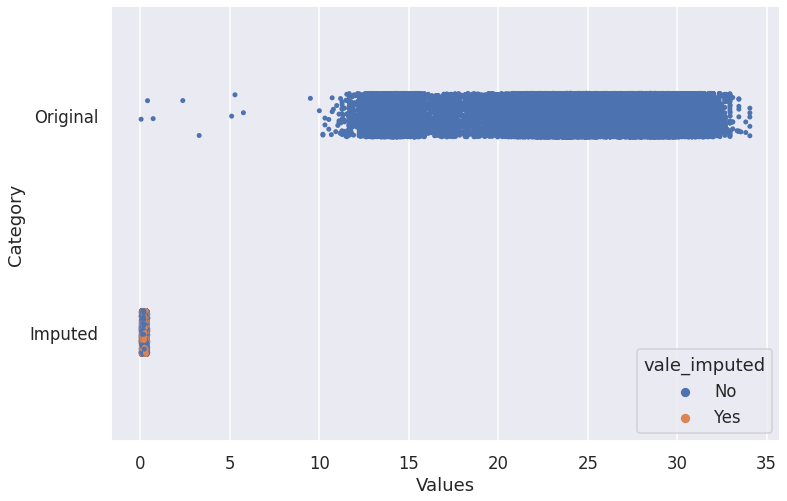

In [65]:
sns.stripplot(x='Values', y='Category', data=part_tot, hue='vale_imputed', jitter=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.



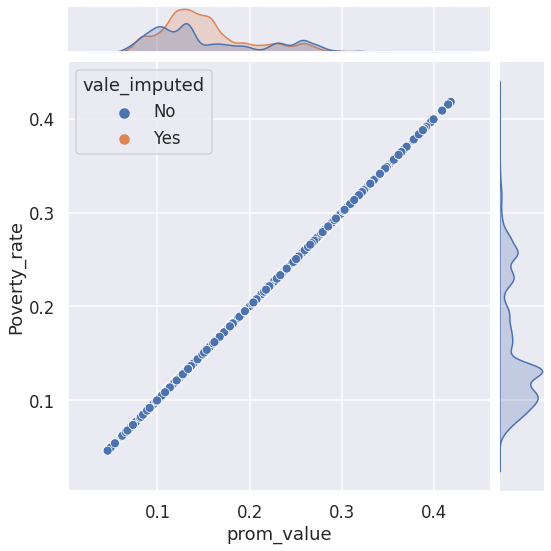

In [66]:
ax = sns.jointplot(data=time_series_t, x="prom_value", y="Poverty_rate", hue='vale_imputed', space=0.2, hue_order=['No', 'Yes'], ratio=8,  height=8)

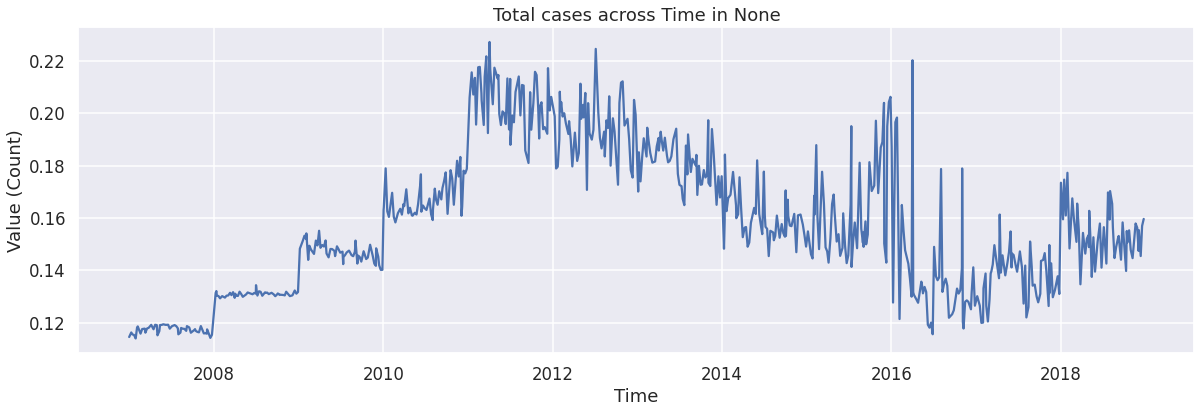

In [67]:
plot_time_series_temp = time_series_t.groupby('Date')['prom_value'].mean().reset_index(name= 'mean')
fig, ax1 = plt.subplots(figsize=(20,6))
ax = sns.lineplot(x='Date',y='mean', data=plot_time_series_temp)
ax.set_title('Total cases across Time in {}'.format(city))
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

In [68]:
temp = time_series_t[['prom_value', variable]].copy()
# create the mean imputer
cov = temp.cov()
corr = temp.corr()
cov_corr_df = pd.concat([cov, corr], axis=1)
cov_corr_df.columns = columns=["cov_prom_value", "cov_"+variable, "corr_prom_value", "corr_"+variable]

temp['diff'] = (temp[variable] - temp['prom_value'])**2 
error = np.sqrt(temp['diff'].sum()/len(temp))

print("El error estandar de la imputación es:", error)
print("La varianza de la serie original es:", temp.var().to_dict()[variable])
print("La varianza de la serie imputada es:", temp.var().to_dict()['prom_value'])
print("La differencia de varianza es:",  temp.var().to_dict()[variable] - temp.var().to_dict()['prom_value'])

cov_corr_df

El error estandar de la imputación es: 4.592991282145472e-18
La varianza de la serie original es: 0.004375920635355721
La varianza de la serie imputada es: 0.0034087423418797526
La differencia de varianza es: 0.0009671782934759687


cov_prom_value  ...  corr_Poverty_rate
prom_value          0.003409  ...                1.0
Poverty_rate        0.004376  ...                1.0

[2 rows x 4 columns]

As we can see here the method of imputation was very close to reality, the correlation and covariance not change really 

**Predictive Mean Matching Imputation - Iterative Imputer**

Explicar como funciona Iterative imputer

In [69]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from shapely.geometry import Point, shape

city = None
imputer = IterativeImputer(random_state=101)

imputed_df = pd.DataFrame(imputer.fit_transform(data_transform))

In [70]:
imputed_df

0       1         2         3     4   ...   9    10   11   12   13
0       1.0  3230.0  0.152045  0.033410  31.0  ...  0.0  0.0  0.0  0.0  0.0
1       1.0  9996.0  0.154267  0.034091  25.0  ...  0.0  0.0  0.0  0.0  0.0
2       1.0  9997.0  0.108300  0.023500  18.0  ...  0.0  0.0  0.0  0.0  0.0
3       1.0  9999.0  0.095400  0.014500  32.0  ...  0.0  0.0  0.0  0.0  0.0
4       1.0  9997.0  0.095400  0.014500  21.0  ...  0.0  0.0  0.0  0.0  0.0
...     ...     ...       ...       ...   ...  ...  ...  ...  ...  ...  ...
137082  1.0  9997.0  0.178600  0.035100   8.0  ...  0.0  0.0  0.0  0.0  1.0
137083  1.0  9997.0  0.217700  0.028000  19.0  ...  0.0  0.0  0.0  0.0  0.0
137084  1.0  9997.0  0.194800  0.009700   9.0  ...  0.0  0.0  0.0  0.0  0.0
137085  1.0  9997.0  0.194800  0.009700  11.0  ...  0.0  0.0  0.0  0.0  1.0
137086  1.0  9997.0  0.178600  0.035100   6.0  ...  0.0  0.0  0.0  0.0  0.0

[137087 rows x 14 columns]

In [71]:


porverty_original = data_transform[['Poverty_rate']].copy()
porverty_original = porverty_original.rename(columns= {'Poverty_rate':'Values'})
porverty_original['Category'] = 'Original'
porverty_original['index'] = porverty_original.index
list_imputed = list(porverty_original[porverty_original['Values'].isnull()]['index'])


porverty_original['vale_imputed'] = 'No'

poverty_imputed = imputed_df[[2]].copy()
poverty_imputed = poverty_imputed.rename(columns= {2:'Values'})
poverty_imputed['Category'] = 'Imputed'
poverty_imputed['index'] = poverty_imputed.index
poverty_imputed['vale_imputed'] = poverty_imputed['index'].apply(lambda x: 'Yes' if x in list_imputed else 'No')

porverty_tot = porverty_original.append(poverty_imputed)



In [72]:

porverty_tot_filter = poverty_imputed.copy()
time_series = data_imputation.copy()
time_series['index'] = time_series.index
time_series_poverty = time_series.merge(porverty_tot_filter[['Values','index','vale_imputed']], on='index', how='left')
if city is not None:
  time_series_t = time_series_poverty[time_series_t['Municipio_residencia'] == city]

In [73]:
time_series_poverty['Values'].isnull().sum()

636

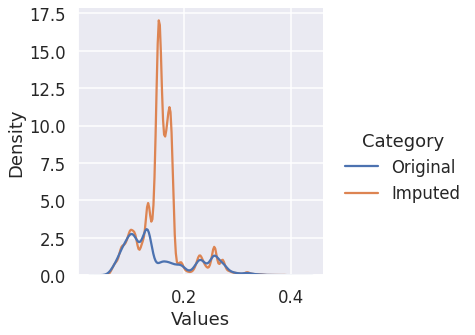

In [74]:
sns.displot(porverty_tot, x="Values", hue="Category", kind="kde")

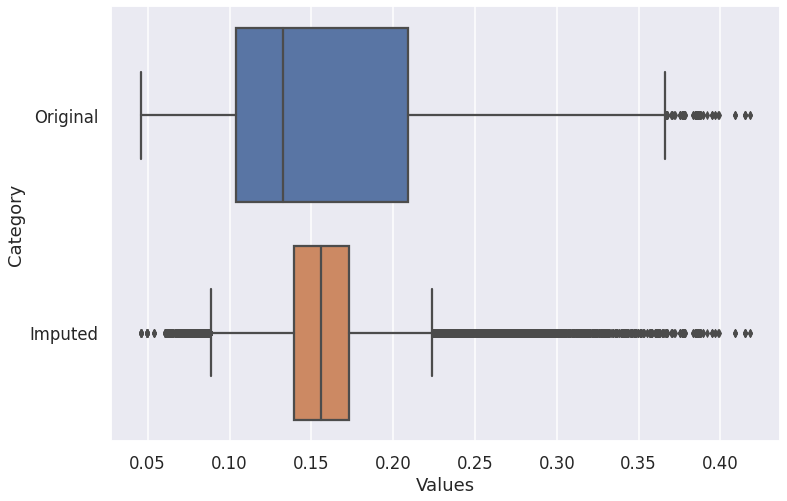

In [75]:
ax = sns.boxplot(x="Values", y="Category", data=porverty_tot)

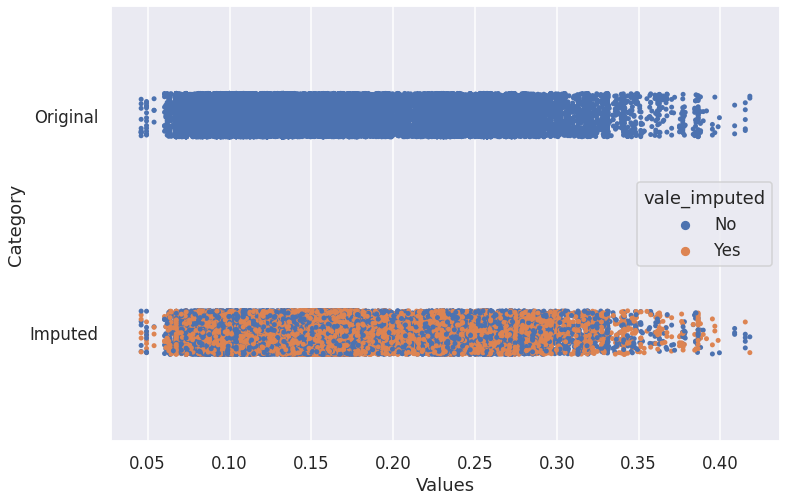

In [76]:
sns.stripplot(x='Values', y='Category', data=porverty_tot, hue='vale_imputed', jitter=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.



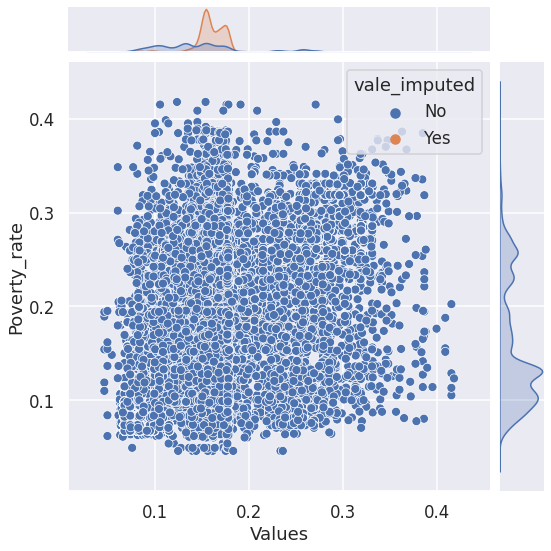

In [77]:
ax = sns.jointplot(data=time_series_poverty, x="Values", y="Poverty_rate", hue='vale_imputed', space=0.2, hue_order=['No', 'Yes'], ratio=8,  height=8)

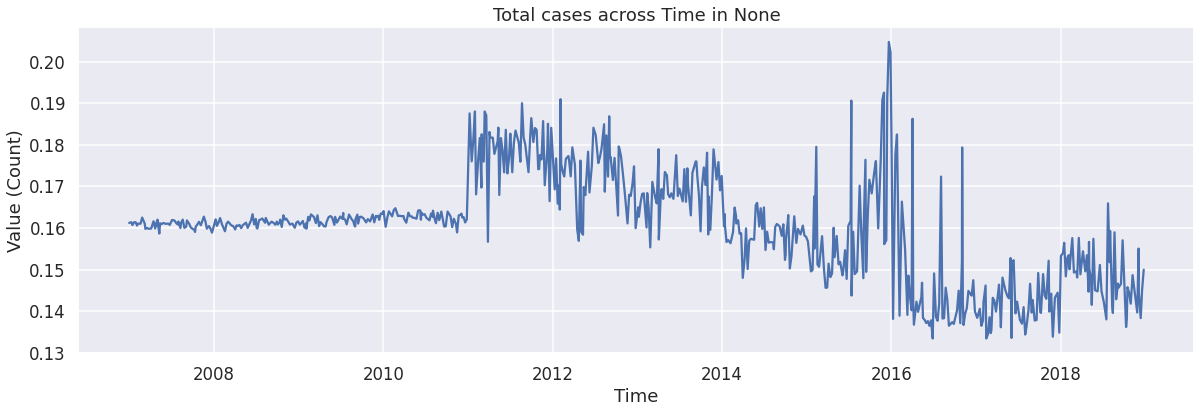

In [78]:
plot_time_series_temp = time_series_poverty.groupby('Date')['Values'].mean().reset_index(name= 'mean')
fig, ax1 = plt.subplots(figsize=(20,6))
ax = sns.lineplot(x='Date',y='mean', data=plot_time_series_temp)
ax.set_title('Total cases across Time in {}'.format(city))
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

In [79]:
variable = 'Poverty_rate'
temp = time_series_poverty[['Values', variable]].copy()
# create the mean imputer
cov = temp.cov()
corr = temp.corr()
cov_corr_df = pd.concat([cov, corr], axis=1)
cov_corr_df.columns = columns=["cov_prom_value", "cov_"+variable, "corr_prom_value", "corr_"+variable]

temp['diff'] = (temp[variable] - temp['Values'])**2 
error = np.sqrt(temp['diff'].sum()/len(temp))

print("El error estandar de la imputación es:", error)
print("La varianza de la serie original es:", temp.var().to_dict()[variable])
print("La varianza de la serie imputada es:", temp.var().to_dict()['Values'])
print("La differencia de varianza es:", temp.var().to_dict()['diff'])

cov_corr_df

El error estandar de la imputación es: 0.03342767508860131
La varianza de la serie original es: 0.004375920635355721
La varianza de la serie imputada es: 0.0018828140121932208
La differencia de varianza es: 3.634178425733022e-05


cov_prom_value  ...  corr_Poverty_rate
Values              0.001883  ...           0.644629
Poverty_rate        0.002318  ...           1.000000

[2 rows x 4 columns]

**Indigence Rate**

In [80]:

porverty_original = data_transform[['Indigence_rate']].copy()
porverty_original = porverty_original.rename(columns= {'Indigence_rate':'Values'})
porverty_original['Category'] = 'Original'
porverty_original['index'] = porverty_original.index
list_imputed = list(porverty_original[porverty_original['Values'].isnull()]['index'])


porverty_original['vale_imputed'] = 'No'



indigence_imputed = imputed_df[[3]].copy()
indigence_imputed = indigence_imputed.rename(columns= {3:'Values'})
indigence_imputed['Category'] = 'Imputed'
indigence_imputed['index'] = indigence_imputed.index
indigence_imputed['vale_imputed'] = indigence_imputed['index'].apply(lambda x: 'Yes' if x in list_imputed else 'No')

indigence_tot = porverty_original.append(indigence_imputed)



In [81]:

indigence_tot_filter = indigence_imputed.copy()
time_series = data_imputation.copy()
time_series['index'] = time_series.index
time_series_indigence = time_series.merge(indigence_tot_filter[['Values','index','vale_imputed']], on='index', how='left')
if city is not None:
  time_series_indigence = time_series_indigence[time_series_indigence['Municipio_residencia'] == city]

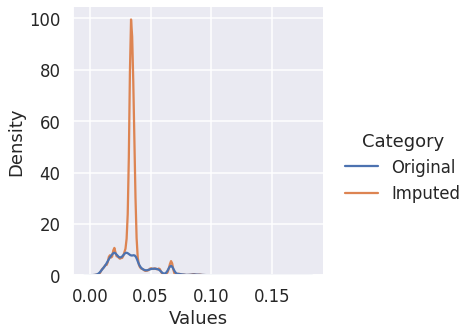

In [82]:
sns.displot(indigence_tot, x="Values", hue="Category", kind="kde")

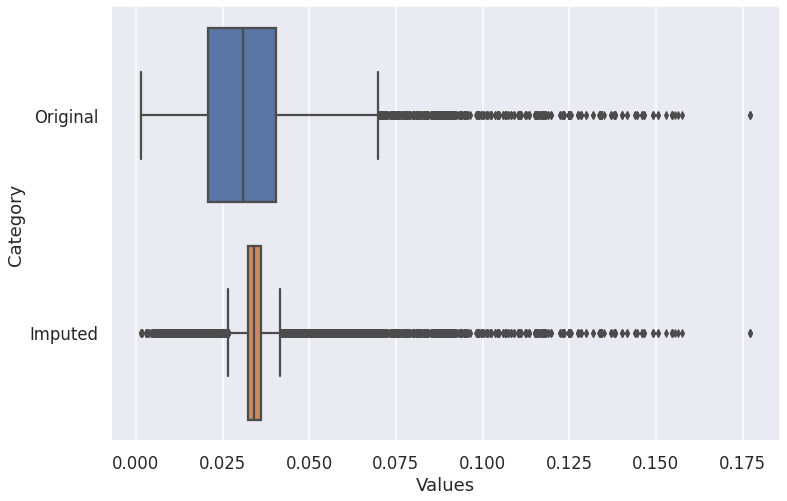

In [83]:
ax = sns.boxplot(x="Values", y="Category", data=indigence_tot)

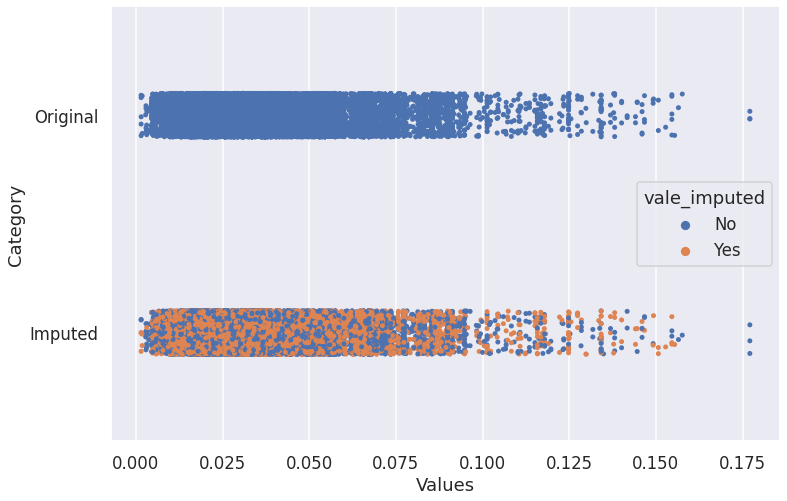

In [84]:
sns.stripplot(x='Values', y='Category', data=indigence_tot, hue='vale_imputed', jitter=True)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:305: UserWarning:

Dataset has 0 variance; skipping density estimate.



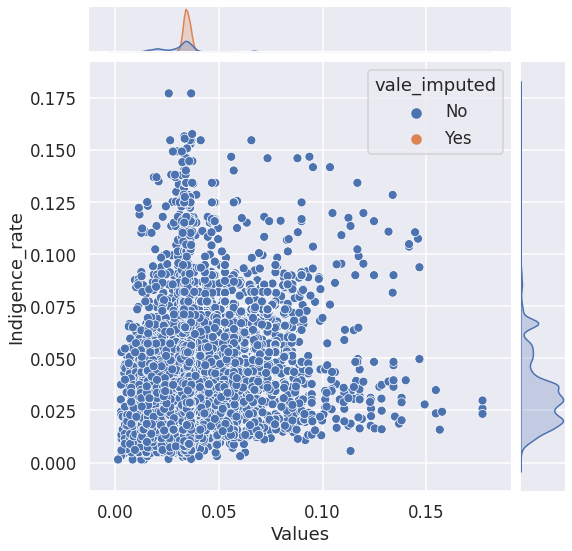

In [85]:
ax = sns.jointplot(data=time_series_indigence, x="Values", y="Indigence_rate", hue='vale_imputed', space=0.2, hue_order=['No', 'Yes'], ratio=8,  height=8)

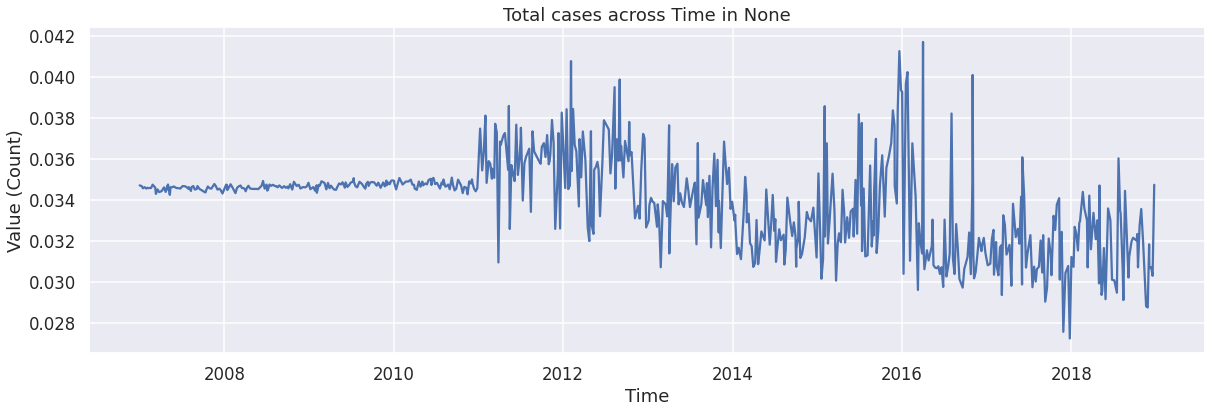

In [86]:
plot_time_series_temp = time_series_indigence.groupby('Date')['Values'].mean().reset_index(name= 'mean')
fig, ax1 = plt.subplots(figsize=(20,6))
ax = sns.lineplot(x='Date',y='mean', data=plot_time_series_temp)
ax.set_title('Total cases across Time in {}'.format(city))
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

In [87]:
variable = 'Indigence_rate'
temp = time_series_indigence[['Values', variable]].copy()
# create the mean imputer
cov = temp.cov()
corr = temp.corr()
cov_corr_df = pd.concat([cov, corr], axis=1)
cov_corr_df.columns = columns=["cov_prom_value", "cov_"+variable, "corr_prom_value", "corr_"+variable]

temp['diff'] = (temp[variable] - temp['Values'])**2 
error = np.sqrt(temp['diff'].sum()/len(temp))

print("El error estandar de la imputación es:", error)
print("La varianza de la serie original es:", temp.var().to_dict()[variable])
print("La varianza de la serie imputada es:", temp.var().to_dict()['Values'])
print("La differencia de varianza es:", temp.var().to_dict()['diff'])

cov_corr_df

El error estandar de la imputación es: 0.010205741782167179
La varianza de la serie original es: 0.00030745032094751256
La varianza de la serie imputada es: 0.0001286671400460723
La differencia de varianza es: 5.765061641300937e-07


cov_prom_value  ...  corr_Indigence_rate
Values                0.000129  ...             0.510504
Indigence_rate        0.000125  ...             1.000000

[2 rows x 4 columns]

# Complete Data Base

In [88]:
variable = "tavg"
strategy = "interpolate"
city = None
table_result_temp = imputation_method(variable, strategy, n = 3)
part_tot, time_series_temp = tables_temp(city)

variable = "prcp"
strategy = "interpolate"
city = None
table_result_temp = imputation_method(variable, strategy, n = 3)
part_tot, time_series_preci = tables_temp(city)

time_series_pov = time_series_poverty.copy()

time_series_ind = time_series_indigence.copy()

MultipleImputer(n=3, return_list=True, seed=101, strategy='interpolate')
MultipleImputer(n=3, return_list=True, seed=101, strategy='interpolate')


In [89]:
time_series = time_series_temp.rename(columns={'prom_value':'Fixed_temp'})
time_series_1 = time_series_preci[['index', 'prom_value']].rename(columns={'prom_value':'Fixed_prep'})
time_series_2 = time_series_pov[['index', 'Values']].rename(columns={'Values':'Fixed_poverty'})
time_series_3 = time_series_ind[['index', 'Values']].rename(columns={'Values':'Fixed_indigence'})


clean_dataframe_1 = time_series.merge(time_series_1, on= 'index', how = 'left', suffixes=('', '_'))
clean_dataframe_2 = clean_dataframe_1.merge(time_series_2, on= 'index', how = 'left', suffixes=('', '_'))
clean_dataframe = clean_dataframe_2.merge(time_series_3, on= 'index', how = 'left', suffixes=('', '_'))ç

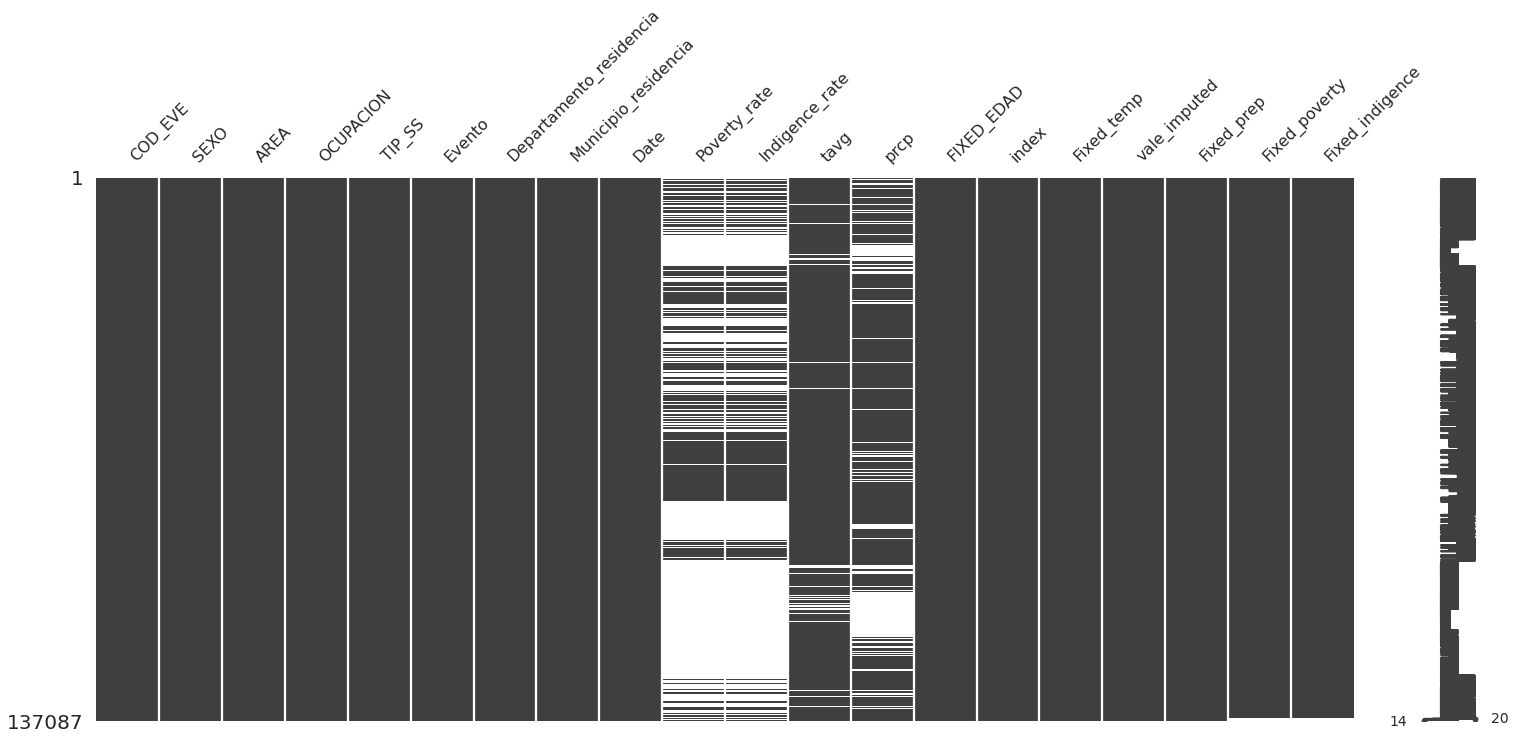

In [90]:
plot_md_locations(clean_dataframe)


In [91]:
clean_dataframe = clean_dataframe.drop(['Poverty_rate', 'Indigence_rate', 'tavg', 'prcp'], axis=1)
clean_dataframe = clean_dataframe.dropna()


In [92]:
clean_dataframe.shape

(136451, 16)

In [93]:
cat_features = clean_dataframe.select_dtypes(include = ["object", "category"]).columns
cat_features = cat_features[:2]
one_hot = pd.get_dummies(clean_dataframe[cat_features])

clean_dataframe = pd.concat([clean_dataframe, one_hot], axis = 1)

clean_dataframe.head(5)

COD_EVE SEXO  AREA  OCUPACION  ... TIP_SS_I TIP_SS_N TIP_SS_P TIP_SS_S
0      810    M     1       3230  ...        0        0        0        0
1      810    F     1       9996  ...        0        0        0        0
2      810    M     1       9997  ...        0        0        0        0
3      810    M     1       9999  ...        0        0        0        0
4      810    M     1       9997  ...        0        0        0        0

[5 rows x 25 columns]

In [94]:
df = clean_dataframe.copy()
df['Date'] = pd.to_datetime(df['Date'])

In [96]:
import datetime
df.to_excel("data/Input_to_Model"+str(datetime.datetime.now())+".xlsx")

In [97]:
clean_dataframe['COD_EVE'].unique()

array([810, 895, 220])

In [98]:
Enfermedad = 810
df_tuerculosis = df.copy()
df_tuerculosis = df_tuerculosis[df_tuerculosis['COD_EVE'] == Enfermedad]
df_tuerculosis['row'] = 1
count_cases_per_day = df_tuerculosis.groupby('Date')['row'].sum().reset_index()
df_tuerculosis = df_tuerculosis.merge(count_cases_per_day, on='Date', how='left')
df_tuerculosis = df_tuerculosis.rename(columns={'row_y':'count_cases'})

In [99]:
Enfermedad = 895
df_zika = df.copy()
df_zika = df_zika[df_zika['COD_EVE'] == Enfermedad]
df_zika['row'] = 1
count_cases_per_day = df_zika.groupby('Date')['row'].sum().reset_index()
df_zika = df_zika.merge(count_cases_per_day, on='Date', how='left')
df_zika = df_zika.rename(columns={'row_y':'count_cases'})

In [100]:
Enfermedad = 220
df_dengue = df.copy()
df_dengue = df_dengue[df_dengue['COD_EVE'] == Enfermedad]
df_dengue['row'] = 1
count_cases_per_day = df_dengue.groupby('Date')['row'].sum().reset_index()
df_dengue = df_dengue.merge(count_cases_per_day, on='Date', how='left')
df_dengue = df_dengue.rename(columns={'row_y':'count_cases'})

# Correlation Analysis

**Tuberculosis**

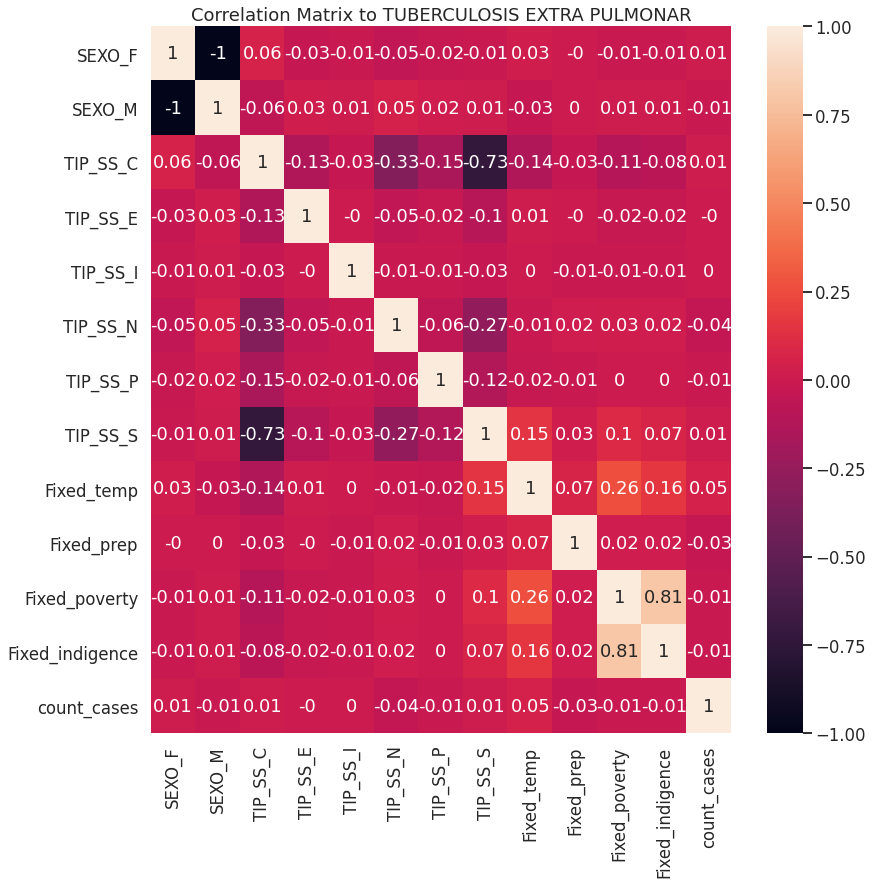

In [101]:
fig, ax = plt.subplots(figsize=(13,13))
inter=df_tuerculosis[['SEXO_F',	'SEXO_M',	'TIP_SS_C',	'TIP_SS_E',	'TIP_SS_I',	'TIP_SS_N',	'TIP_SS_P',	'TIP_SS_S', 'Fixed_temp',	'Fixed_prep',	'Fixed_poverty',	'Fixed_indigence', 'count_cases']]
inter
corrMatrix=round(inter.corr(),2)
ax = sns.heatmap(corrMatrix, annot=True)
ax.set_title('Correlation Matrix to TUBERCULOSIS EXTRA PULMONAR')
plt.show()

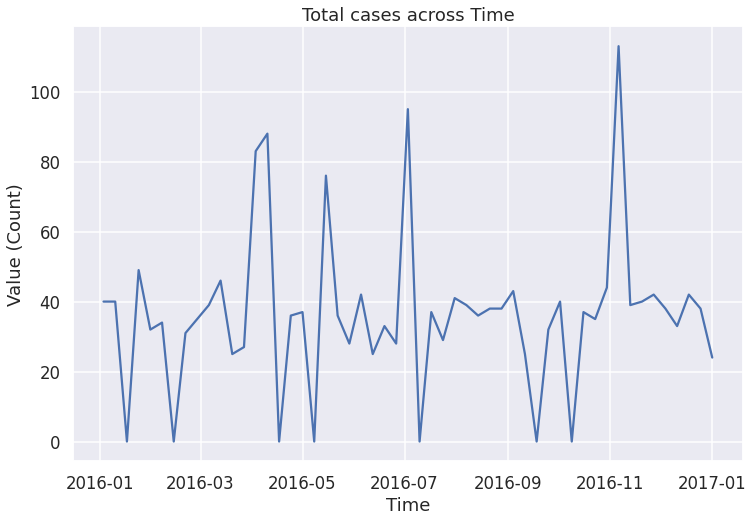

In [103]:
data_transform_tuberculosis2 = df_tuerculosis[df_tuerculosis['Date'].dt.year == 2016]

plot_time_series = data_transform_tuberculosis2.groupby(pd.Grouper(freq="W", key ='Date'))['OCUPACION'].count().reset_index(name= 'count')

ax = sns.lineplot(x='Date',y='count', data=plot_time_series)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

In [104]:
plot_time_series = plot_time_series[plot_time_series['count'] > 0]

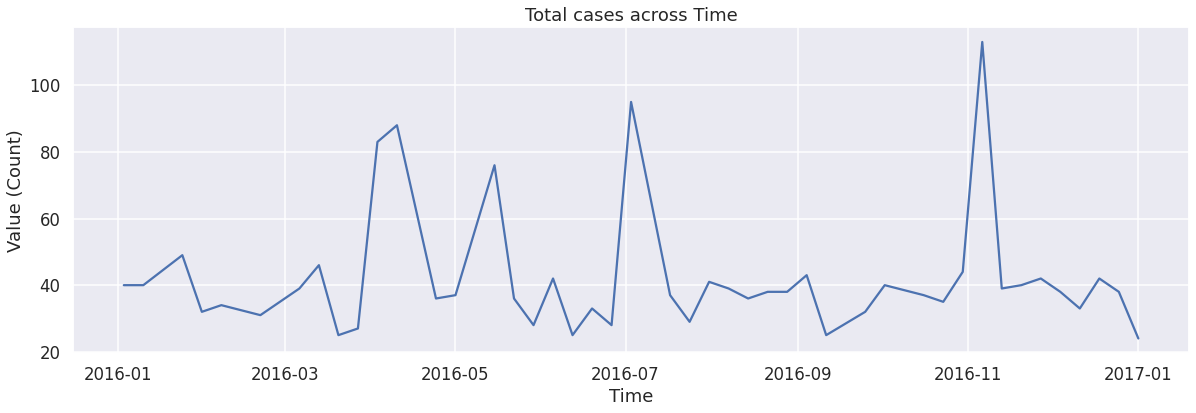

In [105]:
fig, ax1 = plt.subplots(figsize=(20,6))

ax = sns.lineplot(x='Date',y='count', data=plot_time_series)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

In [110]:


plot_time_series_temp = df_tuerculosis.groupby(pd.Grouper(freq="W", key ='Date'))['prcp'].mean().reset_index(name= 'count')

fig, ax1 = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='count', data=plot_time_series_temp)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

KeyError: ignored

In [113]:
plot_time_series_temp = data_transform_tuberculosis2.groupby(pd.Grouper(freq="W", key ='Date'))['tavg'].mean().reset_index(name= 'count')

fig, ax1 = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='count', data=plot_time_series_temp)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

KeyError: ignored

In [114]:
plot_time_series_temp = data_transform_tuberculosis.groupby(pd.Grouper(freq="W", key ='Date'))['Poverty_rate'].mean().reset_index(name= 'count')

fig, ax1 = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='count', data=plot_time_series_temp)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

NameError: ignored

In [115]:
plot_time_series_temp = data_transform_tuberculosis.groupby(pd.Grouper(freq="W", key ='Date'))['Indigence_rate'].mean().reset_index(name= 'count')

fig, ax1 = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='count', data=plot_time_series_temp)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

NameError: ignored

In [116]:
# Zika
Enfermedad = 895
data_filter_2 = data_filter.copy()
data_filter_2 = data_filter_2[data_filter_2['COD_EVE'] == Enfermedad]
data_filter_temp = data_filter_2[['COD_EVE', 'AREA',	'OCUPACION', 'Evento',	'Departamento_residencia',	'Municipio_residencia',	'Date',	'Poverty_rate',	'Indigence_rate',	'tavg',	'prcp']]
cat_features = data_filter_2.select_dtypes(include = ["object", "category"]).columns
cat_features = cat_features[:2]
one_hot = pd.get_dummies(data_filter_2[cat_features])

data_transform_zika = pd.concat([data_filter_temp, one_hot], axis = 1)

data_transform_zika['Date'] = pd.to_datetime(data_transform_zika['Date'])
data_transform_zika['count_cases'] = data_transform_zika.groupby(pd.Grouper(freq="W", key ='Date'))['OCUPACION'].count().reset_index(name= 'count')['count']
data_transform_zika.head(1)

COD_EVE  AREA  OCUPACION  ... TIP_SS_P TIP_SS_S count_cases
22351      895     1       9999  ...        0        1         NaN

[1 rows x 20 columns]

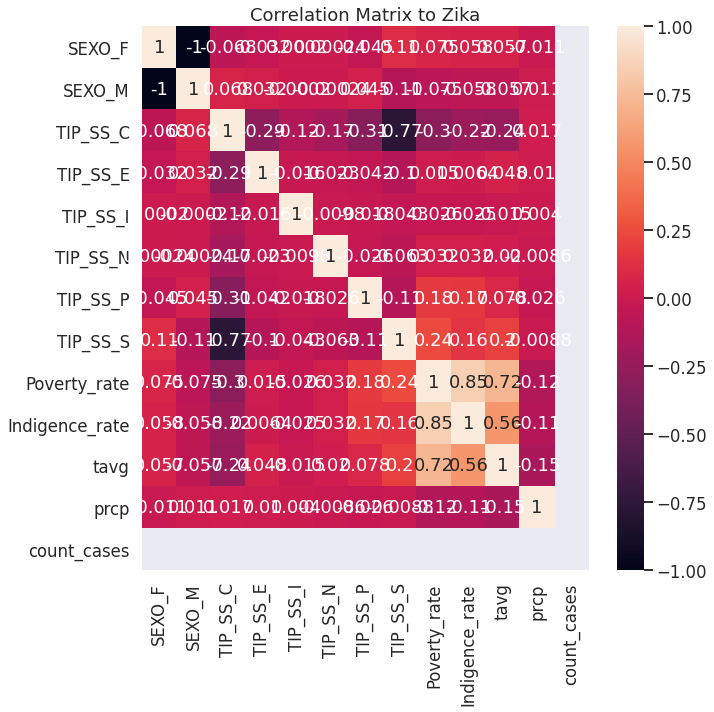

In [117]:
fig, ax = plt.subplots(figsize=(10,10))
inter=data_transform_zika[['SEXO_F',	'SEXO_M',	'TIP_SS_C',	'TIP_SS_E',	'TIP_SS_I',	'TIP_SS_N',	'TIP_SS_P',	'TIP_SS_S', 'Poverty_rate',	'Indigence_rate',	'tavg',	'prcp', 'count_cases']]
inter
corrMatrix=inter.corr()
ax = sns.heatmap(corrMatrix, annot=True)
ax.set_title('Correlation Matrix to Zika')
plt.show()

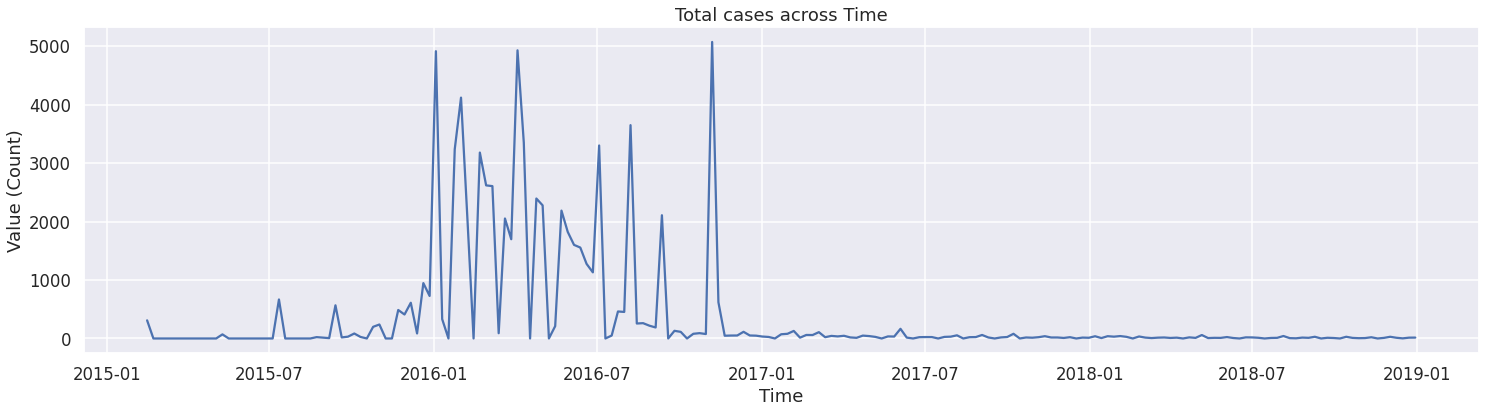

In [118]:
plot_time_series_temp = data_transform_zika.groupby(pd.Grouper(freq="W", key ='Date'))['OCUPACION'].count().reset_index(name= 'count')
plot_time_series = plot_time_series[plot_time_series['count'] > 0]
fig, ax1 = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='count', data=plot_time_series_temp)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

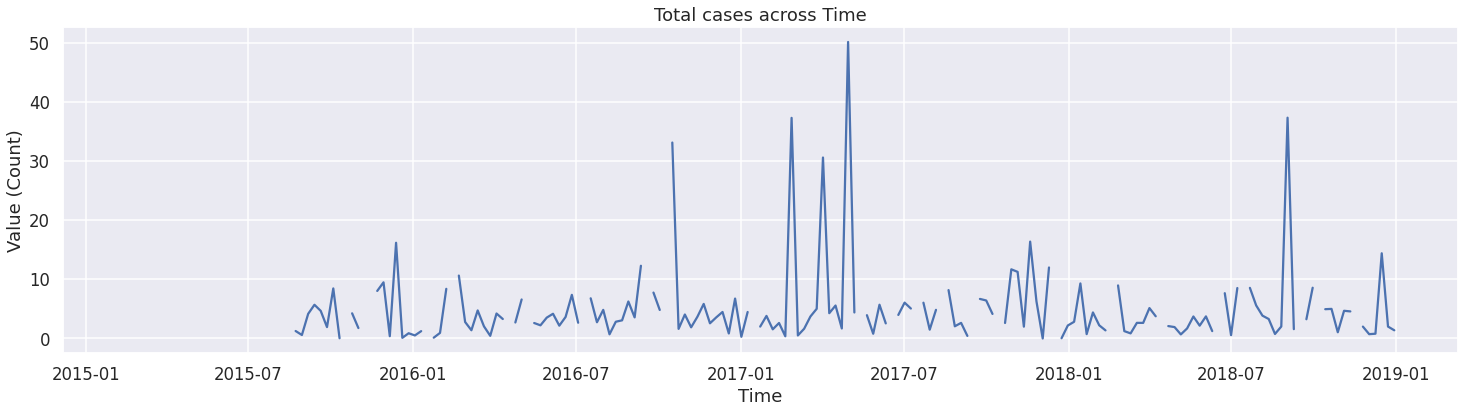

In [119]:
plot_time_series_temp = data_transform_zika.groupby(pd.Grouper(freq="W", key ='Date'))['prcp'].mean().reset_index(name= 'count')

fig, ax1 = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='count', data=plot_time_series_temp)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

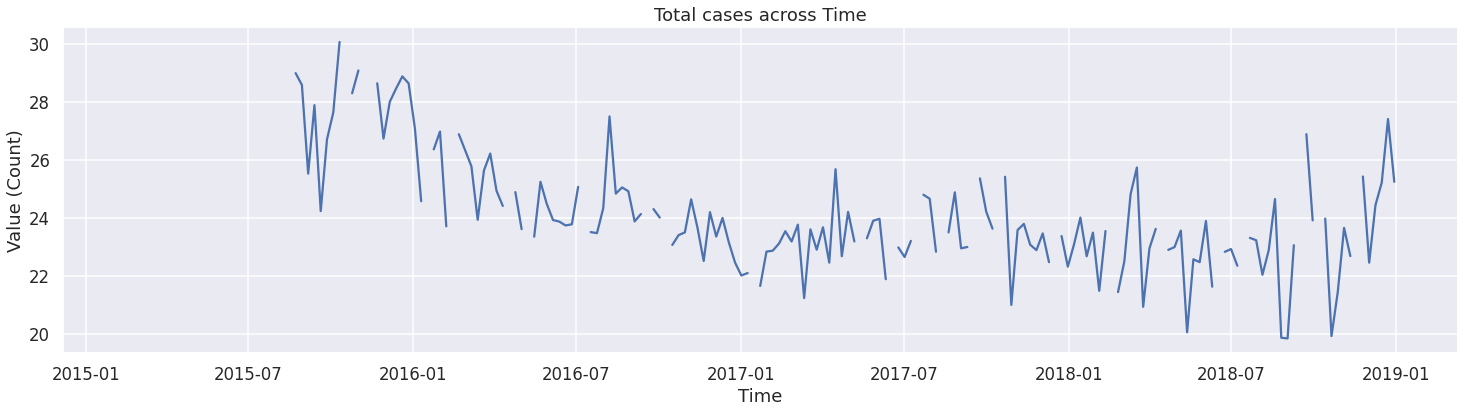

In [120]:
plot_time_series_temp = data_transform_zika.groupby(pd.Grouper(freq="W", key ='Date'))['tavg'].mean().reset_index(name= 'count')

fig, ax1 = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='count', data=plot_time_series_temp)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show() 

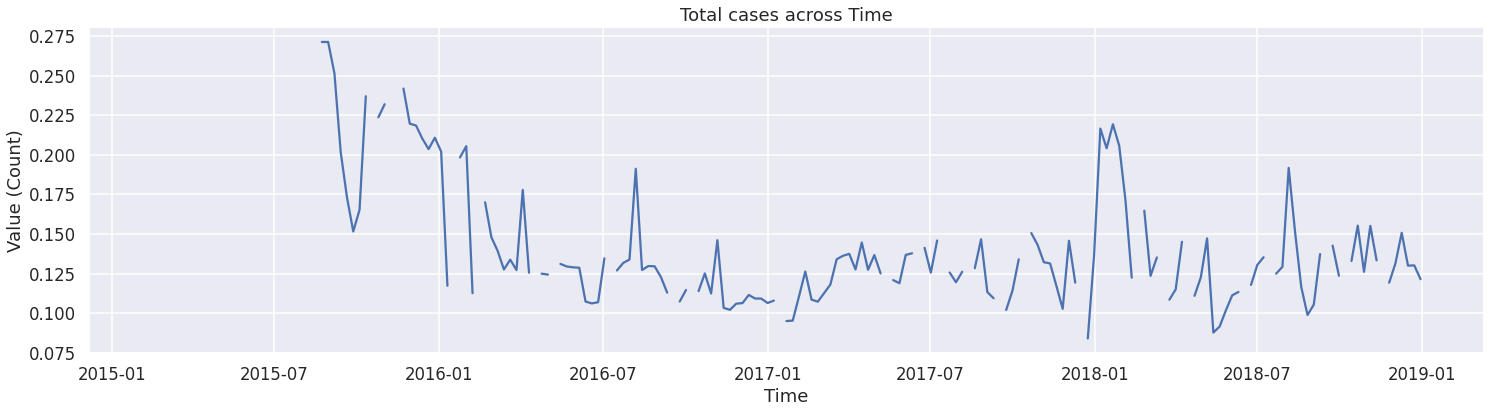

In [121]:
plot_time_series_temp = data_transform_zika.groupby(pd.Grouper(freq="W", key ='Date'))['Poverty_rate'].mean().reset_index(name= 'count')

fig, ax1 = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='count', data=plot_time_series_temp)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show() 

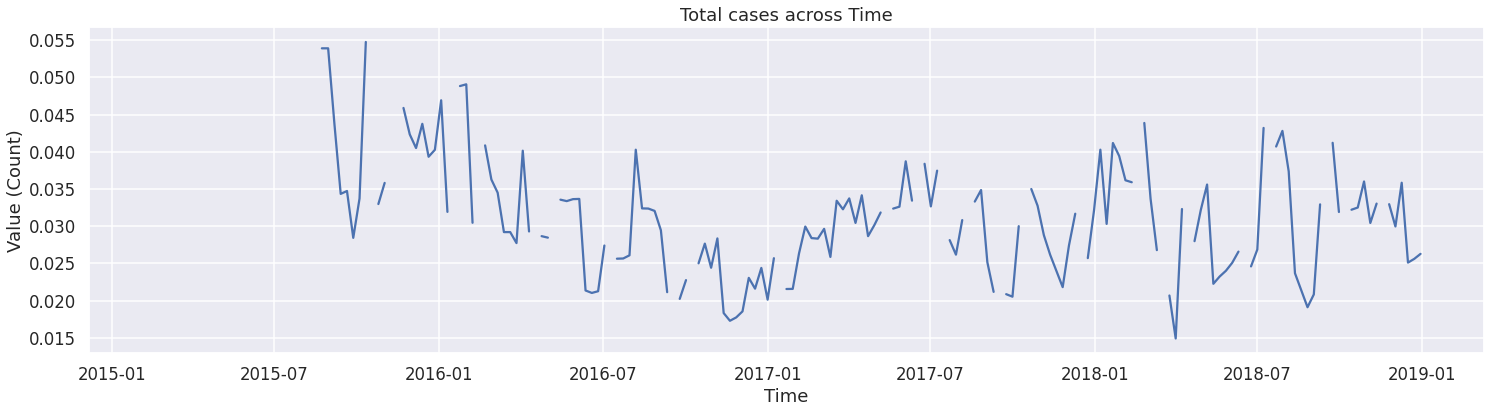

In [122]:
plot_time_series_temp = data_transform_zika.groupby(pd.Grouper(freq="W", key ='Date'))['Indigence_rate'].mean().reset_index(name= 'count')

fig, ax1 = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='count', data=plot_time_series_temp)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show() 

In [123]:
# Dengue
Enfermedad = 220
data_filter_2 = data_filter.copy()
data_filter_2 = data_filter_2[data_filter_2['COD_EVE'] == Enfermedad]
data_filter_temp = data_filter_2[['COD_EVE', 'AREA',	'OCUPACION', 'Evento',	'Departamento_residencia',	'Municipio_residencia',	'Date',	'Poverty_rate',	'Indigence_rate',	'tavg',	'prcp']]
cat_features = data_filter_2.select_dtypes(include = ["object", "category"]).columns
cat_features = cat_features[:2]
one_hot = pd.get_dummies(data_filter_2[cat_features])

data_transform_dengue = pd.concat([data_filter_temp, one_hot], axis = 1)

data_transform_dengue['Date'] = pd.to_datetime(data_transform_dengue['Date'])
data_transform_dengue['count_cases'] = data_transform_dengue.groupby(pd.Grouper(freq="W", key ='Date'))['OCUPACION'].count().reset_index(name= 'count')['count']


KeyError: ignored

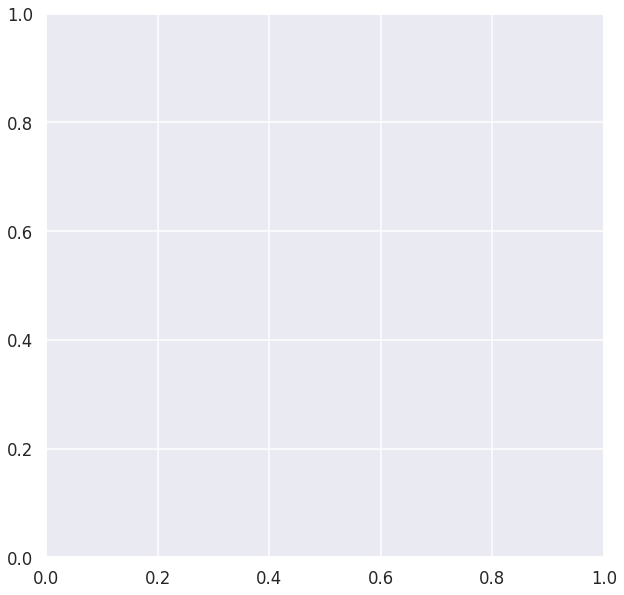

In [124]:
fig, ax = plt.subplots(figsize=(10,10))
inter=data_transform[['SEXO_F',	'SEXO_M',	'TIP_SS_C',	'TIP_SS_E',	'TIP_SS_I',	'TIP_SS_N',	'TIP_SS_P',	'TIP_SS_S', 'Poverty_rate',	'Indigence_rate',	'tavg',	'prcp', 'count_cases']]
inter
corrMatrix=inter.corr()
ax = sns.heatmap(corrMatrix, annot=True)
ax.set_title('Correlation Matrix to Dengue')
plt.show()

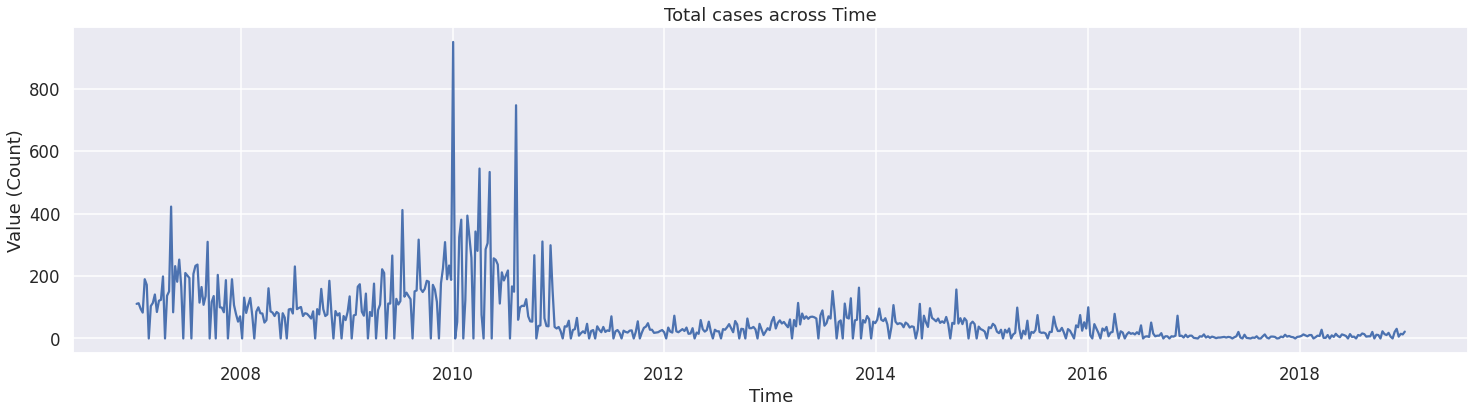

In [125]:
plot_time_series_temp = data_transform_dengue.groupby(pd.Grouper(freq="W", key ='Date'))['OCUPACION'].count().reset_index(name= 'count')
plot_time_series = plot_time_series[plot_time_series['count'] > 0]
fig, ax1 = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='count', data=plot_time_series_temp)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

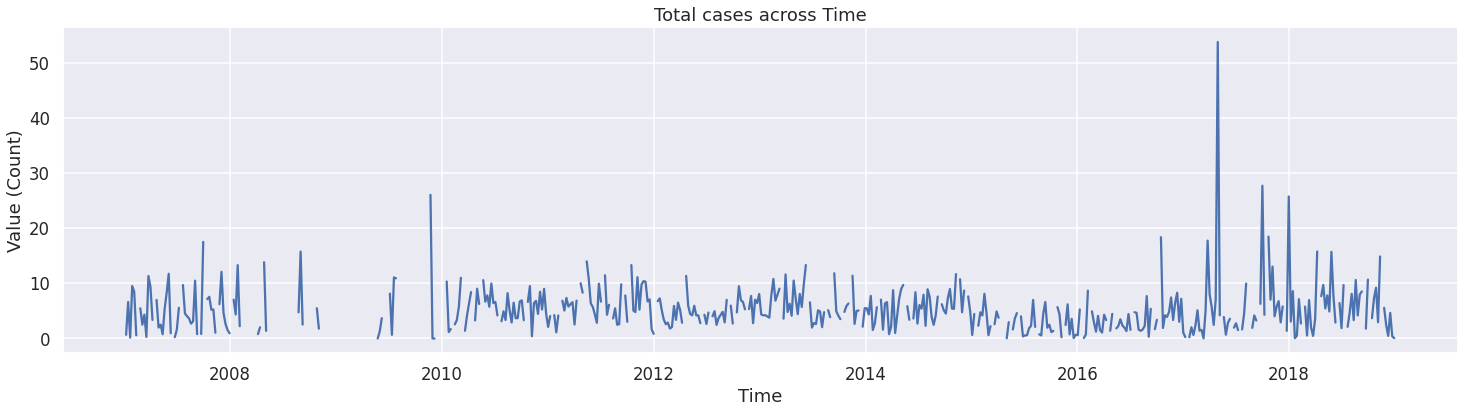

In [126]:
plot_time_series_temp = data_transform_dengue.groupby(pd.Grouper(freq="W", key ='Date'))['prcp'].mean().reset_index(name= 'count')

fig, ax1 = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='count', data=plot_time_series_temp)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

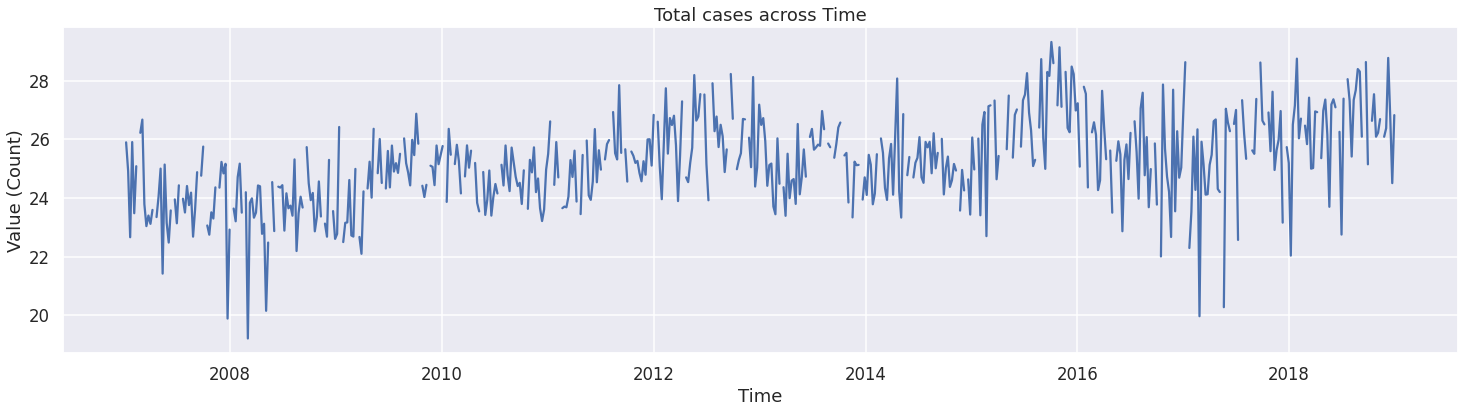

In [127]:
plot_time_series_temp = data_transform_dengue.groupby(pd.Grouper(freq="W", key ='Date'))['tavg'].mean().reset_index(name= 'count')

fig, ax1 = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='count', data=plot_time_series_temp)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

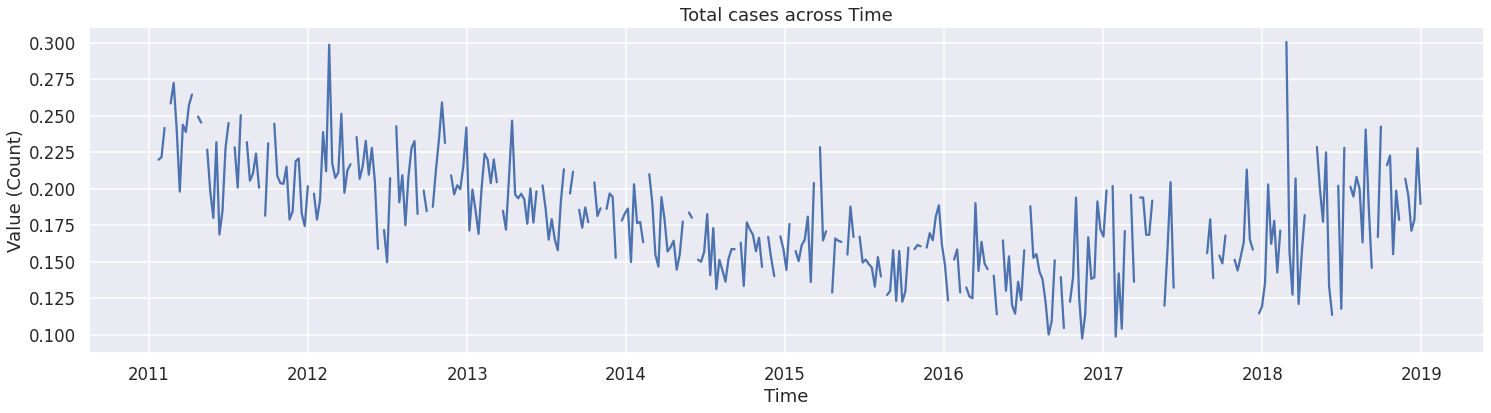

In [128]:
plot_time_series_temp = data_transform_dengue.groupby(pd.Grouper(freq="W", key ='Date'))['Poverty_rate'].mean().reset_index(name= 'count')

fig, ax1 = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='count', data=plot_time_series_temp)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

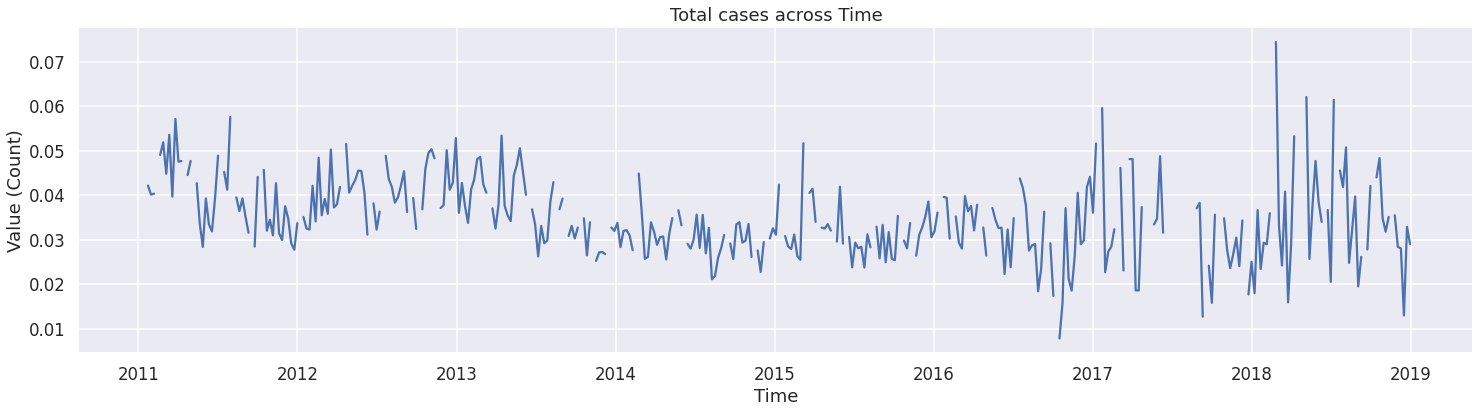

In [129]:
plot_time_series_temp = data_transform_dengue.groupby(pd.Grouper(freq="W", key ='Date'))['Indigence_rate'].mean().reset_index(name= 'count')

fig, ax1 = plt.subplots(figsize=(25,6))

ax = sns.lineplot(x='Date',y='count', data=plot_time_series_temp)
ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time')
plt.show()

In [130]:
data_transform.head(10)

AREA  OCUPACION  Poverty_rate  ...  TIP_SS_N  TIP_SS_P  TIP_SS_S
0     1       3230           NaN  ...         0         0         0
1     1       9996           NaN  ...         0         0         0
2     1       9997        0.1083  ...         0         0         0
3     1       9999        0.0954  ...         0         0         0
4     1       9997        0.0954  ...         0         0         0
5     1       9999        0.1155  ...         0         0         1
6     1       5212        0.1219  ...         0         0         1
7     1       1120        0.1083  ...         0         0         0
8     1       5243        0.0954  ...         0         0         0
9     1       2146        0.1100  ...         0         0         0

[10 rows x 14 columns]

# Models


The process of investigation to analyze what model is the best model is as we show in the methodology.



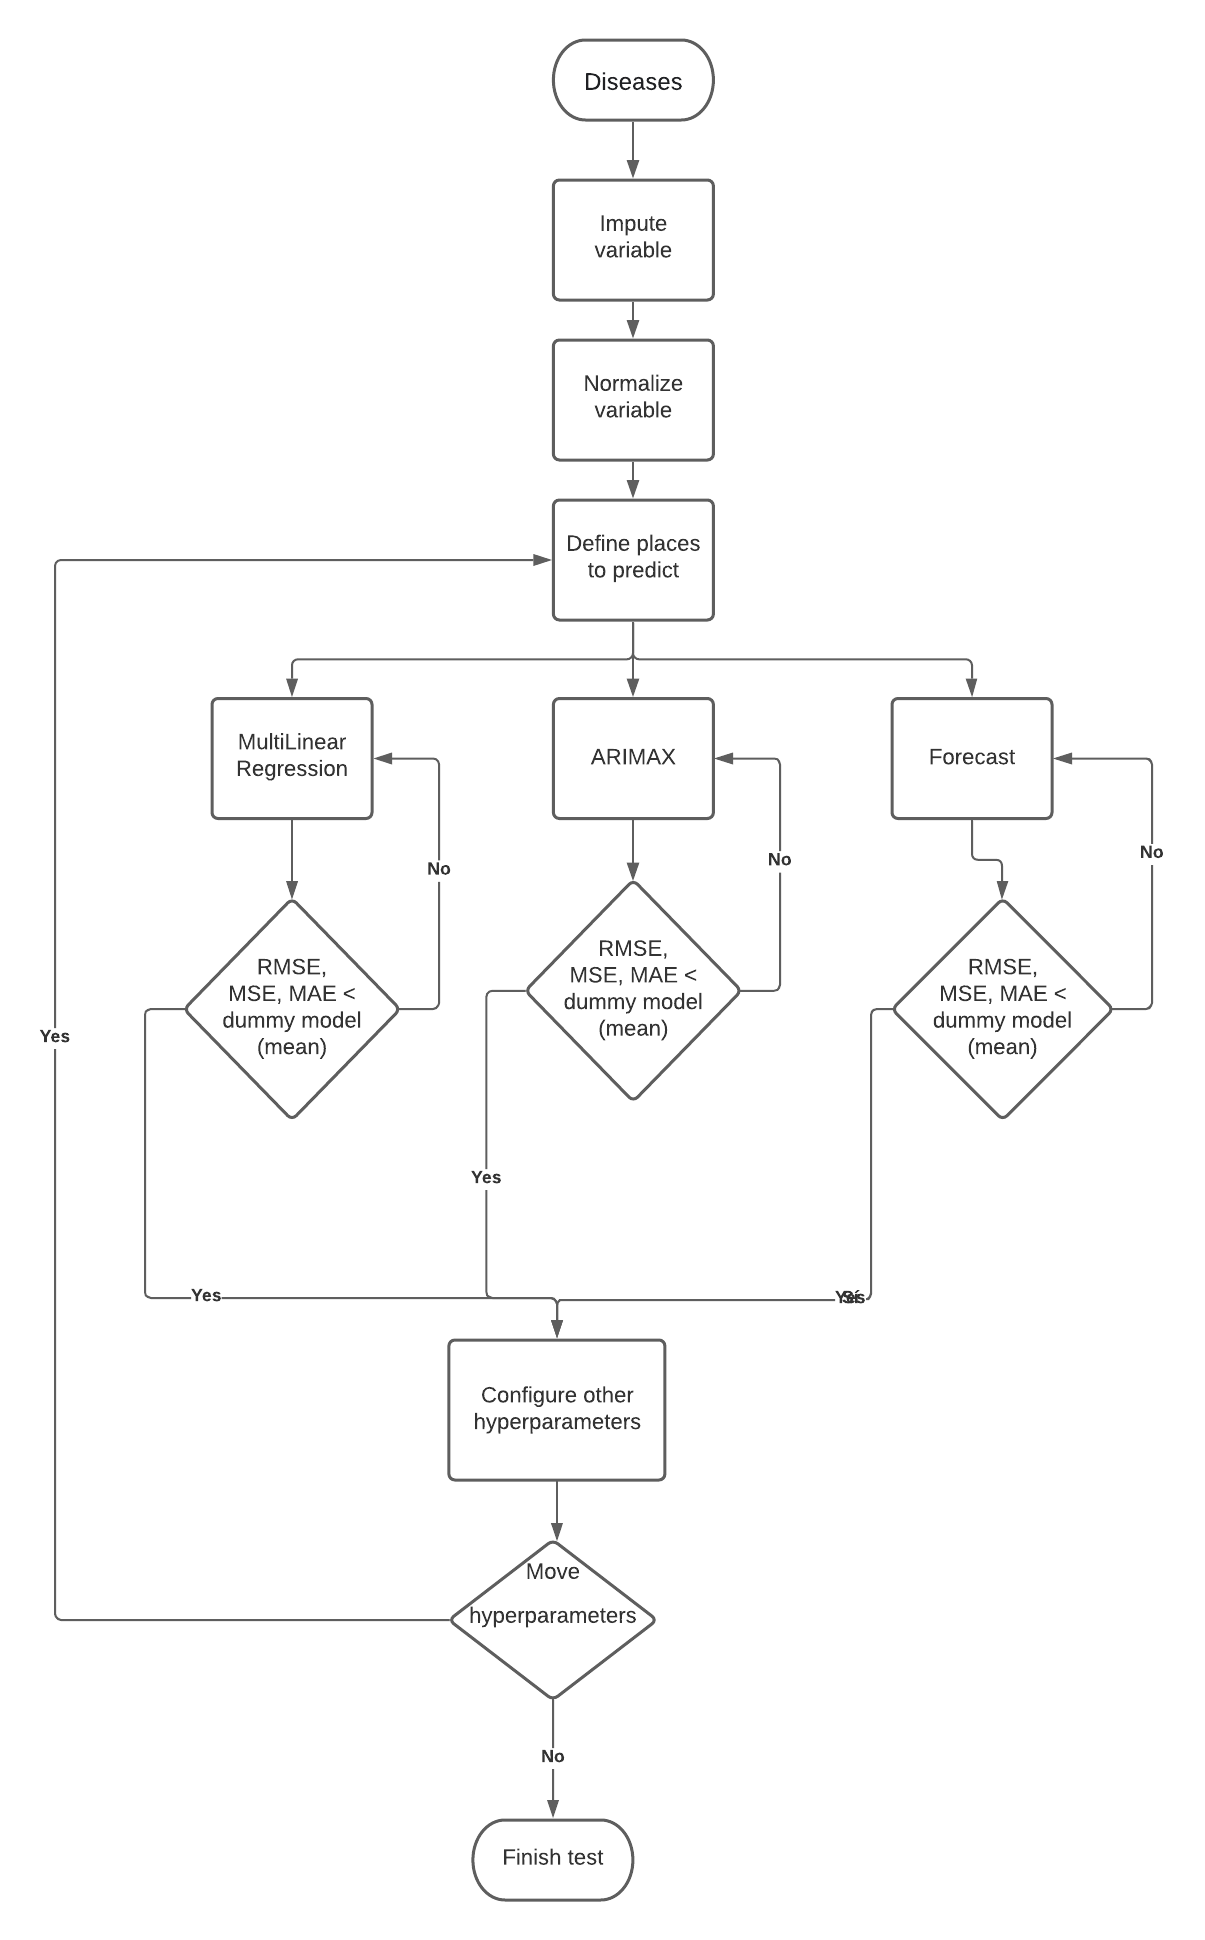


# MultiLinear Regression

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import json
from fbprophet.serialize import model_to_json, model_from_json
from sklearn.metrics import mean_absolute_error, mean_squared_error
from matplotlib import pyplot
import datetime
import pickle



In [145]:
def linear_regression(input_df, name_base):

  model_name= 'linear_regression'
  input = input_df.copy()
  list_dataframe = []
  departamentos = list(input['Departamento_residencia'].unique())

  for departamento in departamentos:
    print(departamento)
    data = input[input['Departamento_residencia'] == departamento]
    data = data.sort_values(by='Date')

    list_variables = ['Date',
    'FIXED_EDAD',
    'Fixed_temp',
    'Fixed_prep',
    'Fixed_poverty',
    'Fixed_indigence',
    'SEXO_F',
    'SEXO_M',
    'TIP_SS_C',
    'TIP_SS_E',
    'TIP_SS_I',
    'TIP_SS_N',
    'TIP_SS_P',
    'TIP_SS_S',
    'count_cases']

    x_var =  ['FIXED_EDAD',
    'Fixed_temp',
    'Fixed_prep',
    'Fixed_poverty',
    'Fixed_indigence',
    'SEXO_F',
    'SEXO_M',
    'TIP_SS_C',
    'TIP_SS_E',
    'TIP_SS_I',
    'TIP_SS_N',
    'TIP_SS_P',
    'TIP_SS_S']
    y_var = ['count_cases']

    data = data[list_variables]


    size = data.shape[0]
    # if  size < 10:
    #   continue
    train = data[:int(0.7*size)]
    test = data[int(0.7*size):]
    total = train.append(test)

    train_X_aux = train[['Date']].reset_index()
    train_X_aux['id'] = train_X_aux.index
    test_X_aux = test[['Date']].reset_index()
    test_X_aux['id'] = test_X_aux.index
    train_Y_aux = train[['Date']].reset_index()
    train_Y_aux['id'] = train_Y_aux.index
    test_Y_aux = test[['Date']].reset_index()
    test_Y_aux['id'] = test_Y_aux.index
    total_aux = total[['Date']].reset_index()
    total_aux['id'] = total_aux.index

    train_X = train[x_var]
    test_X = test[x_var]
    train_Y = train[y_var]
    test_Y = test[y_var]
    total_X = total[x_var]
    total_Y = total[y_var].copy()

    # Create linear regression object
    regr = linear_model.LinearRegression(fit_intercept=False, normalize= True)

    # Train the model using the training sets
    regr.fit(train_X, train_Y)

    path = 'data/Models/LinearReg/' +name_base+"_"+\
    model_name +"_"+departamento+"_"+str(datetime.datetime.now())+"_"+'serialized_model.pkl'
    with open(path, 'wb') as fout:
      pickle.dump(regr, fout)  # Save model

    # Make predictions using the testing set
    y_pred = regr.predict(total_X)
    y_pred = pd.DataFrame(y_pred, columns = ['y_hat'])
    y_pred['id'] = y_pred.index
    total_Y['index'] = total_Y.index

    error = total_aux.merge(y_pred, on='id', how= 'left')
    error = error.merge(total_Y, on='index', how= 'left')
    error = error.rename(columns = {'count_cases':'y'})

    y_true = error[int(0.7*size):]['y'].values
    y_pred = error[int(0.7*size):]['y_hat'].values
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print('MAE: %.3f' % mae)
    print('MSE: %.3f' % mse)
    print('RMSE: %.3f' % np.sqrt(mse))

    error['MAE'] = mae
    error['MSE'] = mse
    error['RMS'] = np.sqrt(mse)
    error['Departamento'] = departamento
    aux_1 = error[:int(0.7*size)].copy()
    aux_1['aux_1'] = 0
    aux_1['aux_2'] = 1
    aux_2 = error[int(0.7*size):].copy()
    aux_2['aux_1'] = 0
    aux_2['aux_2'] = 1
    error = aux_1.append(aux_2)
    list_dataframe.append(error)
  return list_dataframe

In [148]:
list_dataframe = linear_regression(df_tuerculosis, "Tuberculosis")
forecast_df = pd.concat(list_dataframe)
forecast_df.to_csv('data/Models/linear_regression_Tuberculosis_df.csv')

ANTIOQUIA
MAE: 6.407
MSE: 65.744
RMSE: 8.108
SANTANDER
MAE: 6.894
MSE: 81.379
RMSE: 9.021
ATLANTICO
MAE: 6.109
MSE: 59.584
RMSE: 7.719
EXTERIOR
MAE: 9.154
MSE: 162.166
RMSE: 12.734
BOLIVAR
MAE: 6.119
MSE: 69.617
RMSE: 8.344
VALLE
MAE: 6.036
MSE: 60.944
RMSE: 7.807
BOGOTA
MAE: 6.493
MSE: 75.143
RMSE: 8.669
CUNDINAMARCA
MAE: 6.194
MSE: 62.817
RMSE: 7.926
TOLIMA
MAE: 6.523
MSE: 72.213
RMSE: 8.498
BOYACA
MAE: 7.377
MSE: 92.510
RMSE: 9.618
CALDAS
MAE: 6.445
MSE: 70.242
RMSE: 8.381
CAUCA
MAE: 8.119
MSE: 117.108
RMSE: 10.822
CAQUETA
MAE: 5.540
MSE: 50.815
RMSE: 7.128
CESAR
MAE: 6.515
MSE: 62.637
RMSE: 7.914
HUILA
MAE: 6.575
MSE: 72.209
RMSE: 8.498
GUAJIRA
MAE: 6.755
MSE: 68.676
RMSE: 8.287
CHOCO
MAE: 6.850
MSE: 80.482
RMSE: 8.971
NORTE SANTANDER
MAE: 6.458
MSE: 74.250
RMSE: 8.617
QUINDIO
MAE: 7.048
MSE: 81.464
RMSE: 9.026
CORDOBA
MAE: 6.668
MSE: 68.180
RMSE: 8.257
NARIÑO
MAE: 6.996
MSE: 73.524
RMSE: 8.575
MAGDALENA
MAE: 6.296
MSE: 62.214
RMSE: 7.888
RISARALDA
MAE: 5.637
MSE: 53.273
RMSE: 7.29

In [147]:
list_dataframe = linear_regression(df_zika, "Zika")
forecast_df = pd.concat(list_dataframe)
forecast_df.to_csv('data/Models/linear_regression_Zika_df.csv')

ANTIOQUIA
MAE: 1035.188
MSE: 1653705.627
RMSE: 1285.965
CORDOBA
MAE: 1093.012
MSE: 1901429.213
RMSE: 1378.923
SUCRE
MAE: 1069.016
MSE: 1760862.542
RMSE: 1326.975
ATLANTICO
MAE: 1172.992
MSE: 2474662.944
RMSE: 1573.106
CAUCA
MAE: 1739.370
MSE: 4652054.644
RMSE: 2156.862
MAGDALENA
MAE: 989.079
MSE: 1631385.007
RMSE: 1277.257
BOGOTA
MAE: 1551.218
MSE: 3540875.989
RMSE: 1881.722
CUNDINAMARCA
MAE: 1022.436
MSE: 1886369.468
RMSE: 1373.452
GUAINIA
MAE: 2460.892
MSE: 8376266.679
RMSE: 2894.178
VALLE
MAE: 1268.612
MSE: 2652050.208
RMSE: 1628.512
NARIÑO
MAE: 2428.799
MSE: 7416353.839
RMSE: 2723.298
PROCEDENCIA DESCONOCIDA
MAE: 11.395
MSE: 129.842
RMSE: 11.395
ARAUCA
MAE: 677.968
MSE: 958310.262
RMSE: 978.933
CASANARE
MAE: 661.806
MSE: 811227.203
RMSE: 900.682
META
MAE: 800.604
MSE: 979268.224
RMSE: 989.580
SANTANDER
MAE: 1020.168
MSE: 1666956.679
RMSE: 1291.107
BOLIVAR
MAE: 2277.448
MSE: 6584268.790
RMSE: 2565.983
HUILA
MAE: 775.643
MSE: 1108880.184
RMSE: 1053.034
TOLIMA
MAE: 1005.205
MSE: 17952

In [149]:
list_dataframe = linear_regression(df_dengue, "Dengue")
forecast_df = pd.concat(list_dataframe)
forecast_df.to_csv('data/Models/linear_regression_Dengue_df.csv')

ATLANTICO
MAE: 49.255
MSE: 3201.370
RMSE: 56.581
BOGOTA
MAE: 146.399
MSE: 26471.087
RMSE: 162.699
BOYACA
MAE: 131.416
MSE: 20511.763
RMSE: 143.219
BOLIVAR
MAE: 53.849
MSE: 3521.568
RMSE: 59.343
CAQUETA
MAE: 130.837
MSE: 18111.035
RMSE: 134.577
CAUCA
MAE: 141.721
MSE: 24326.608
RMSE: 155.970
HUILA
MAE: 133.793
MSE: 20229.035
RMSE: 142.229
CORDOBA
MAE: 34.272
MSE: 1522.771
RMSE: 39.023
META
MAE: 118.683
MSE: 15347.830
RMSE: 123.886
CESAR
MAE: 52.478
MSE: 3457.891
RMSE: 58.804
GUAJIRA
MAE: 78.047
MSE: 7740.430
RMSE: 87.980
ANTIOQUIA
MAE: 121.967
MSE: 16901.212
RMSE: 130.005
MAGDALENA
MAE: 66.740
MSE: 5907.780
RMSE: 76.862
EXTERIOR
MAE: 77.801
MSE: 8018.706
RMSE: 89.547
CHOCO
MAE: 86.957
MSE: 10616.891
RMSE: 103.038
CASANARE
MAE: 120.648
MSE: 18316.762
RMSE: 135.339
NARIÑO
MAE: 21.318
MSE: 743.003
RMSE: 27.258
NORTE SANTANDER
MAE: 110.497
MSE: 16143.697
RMSE: 127.058
QUINDIO
MAE: 106.795
MSE: 14093.465
RMSE: 118.716
SANTANDER
MAE: 121.943
MSE: 18811.295
RMSE: 137.154
CUNDINAMARCA
MAE: 150.

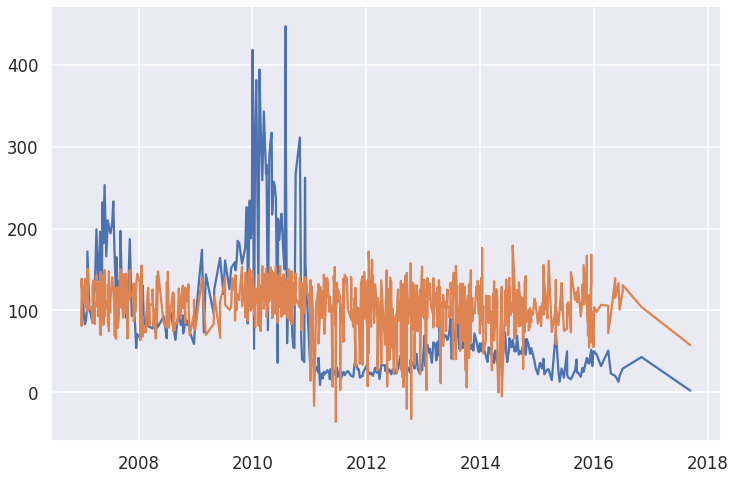

In [150]:
error = list_dataframe[9]
plt.plot(error['Date'], error['y'], label = "Real")
plt.plot(error['Date'], error['y_hat'], label = "Predicted")

**Results**

*Note*

The results section only shows tuberculosis but for all diseases, we had the same behavior.

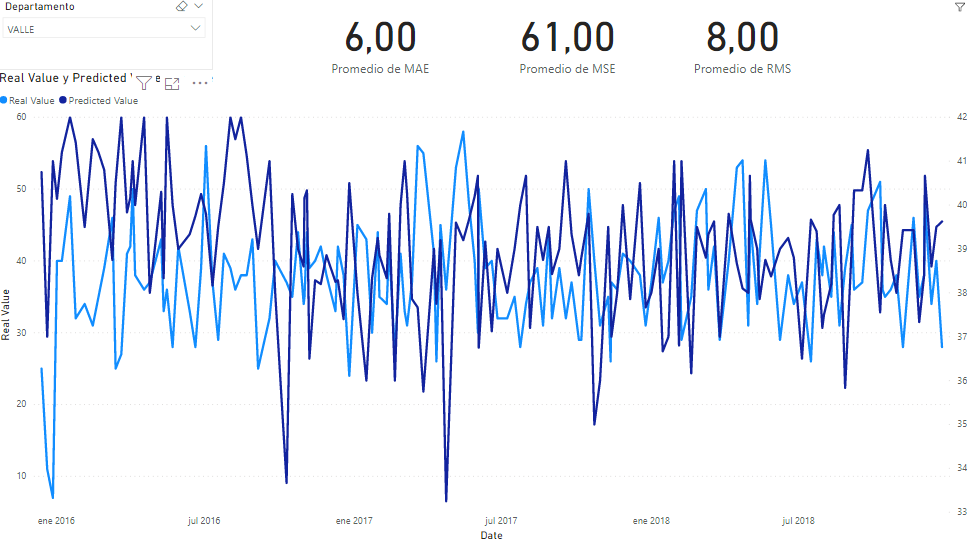

As we can see the MAE and the RMSE error are small, and the chart is proof of this, we can see that the behavior of the real and predicted value in some values are completely different, but still, the predicted waveform maintains a reasonable value of cases of tuberculosis for the department of Valle.

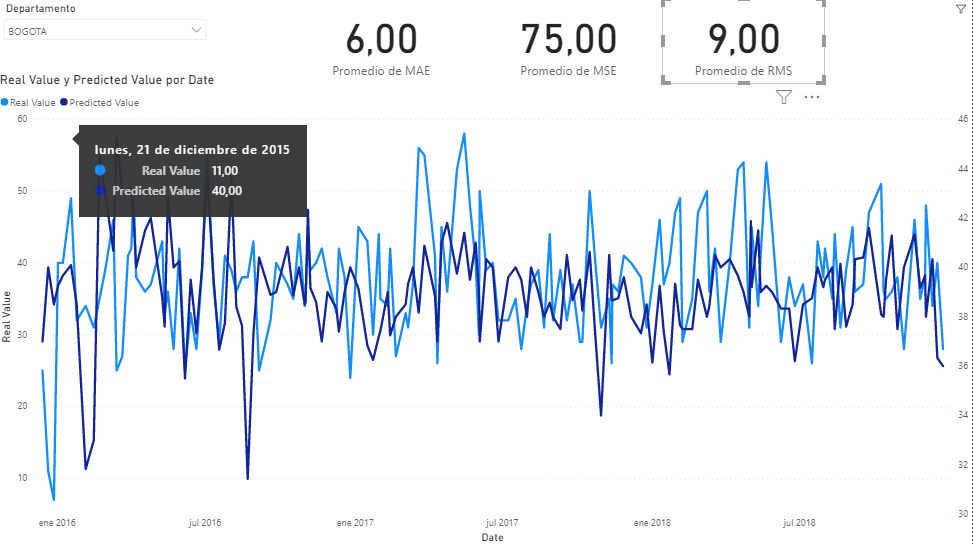

Similar behavior occurs in Bogota, the predicted values maintain reasonable values, and capture the waveform of the real values of tuberculosis. the RMSE, MAE, and MSE are small but is similar if we compare them with the values presents in Valle del Cauca, which means, that the model is capturing the trends of the cases of tuberculosis for differents departments. 

# ARIMAX

In [151]:
import numpy as np
import pandas as pd
import pyflux as pf
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

In [152]:

def ARIMAX(input_df, name_base):
  model_name= 'ARIMAX'
  input = input_df.copy()
  list_dataframe = []
  departamentos = list(input['Departamento_residencia'].unique())

  for departamento in departamentos:
    print(departamento)
    data = input[input['Departamento_residencia'] == departamento]
    data = data.sort_values(by='Date')

    list_variables = ['Date',
    'FIXED_EDAD',
    'Fixed_temp',
    'Fixed_prep',
    'Fixed_poverty',
    'Fixed_indigence',
    'SEXO_F',
    'SEXO_M',
    'TIP_SS_C',
    'TIP_SS_E',
    'TIP_SS_I',
    'TIP_SS_N',
    'TIP_SS_P',
    'TIP_SS_S',
    'count_cases']

    data = data[list_variables]

    size = data.shape[0]
    if  size < 50:
      continue
    train = data[:int(0.7*size)]
    test = data[int(0.7*size):]
    total = train.append(test)

    train_aux = train[['Date']].reset_index()
    train_aux['id'] = train_aux.index

    test_aux = test[['Date']].reset_index()
    test_aux['id'] = test_aux.index

    total_aux = total[['Date']].reset_index()
    total_aux['id'] = total_aux.index


    train = train[list_variables]
    train.index = train['Date']

    test = test[list_variables]
    test.index = test['Date']

    total = total[list_variables].copy()
    total.index = total['Date']

    # Create linear regression object
    model = pf.ARIMAX(data=train, formula='count_cases~1+Fixed_temp +Fixed_prep+Fixed_poverty+Fixed_indigence',
                      ar=3, ma=3, family=pf.Normal())
    x = model.fit("MLE")


    input2 = pd.DataFrame(x.data)
    input2['id'] = input2.index
    input2 = input2.rename(columns={0:'y'})

    out = pd.DataFrame(np.asarray(x.signal))
    out['id'] = out.index
    out = out.rename(columns={0:'y'})

    temp_tain = input2.merge(out, on='id', how='left')
    temp_tain = temp_tain.merge(train_aux, on='id', how='left')
    temp_tain = temp_tain[['y_x','y_y','Date']]
    temp_tain = temp_tain.rename(columns={'y_x':'y','y_y':'y_hat'})

    test_out = model.predict(len(test), test, intervals=False).reset_index()['count_cases']
    test_out = test_out.reset_index()
    test_out = test_out[:-1]
    test_out['id'] = test_out.index


    temp2 = test.drop('Date',axis=1)
    temp2 = temp2.reset_index()
    temp2['id'] = temp2.index

    temp_test = test_out.merge(temp2, on='id', how='left')
    temp_test = temp_test.merge(test_aux, on='id', how='left')
    temp_test = temp_test[['count_cases_x',	'Date_x', 'count_cases_y']]
    temp_test = temp_test.rename(columns={'count_cases_x':'y_hat','count_cases_y':'y', 'Date_x':'Date'})



    error = temp_tain.append(temp_test)


    y_true = error[int(0.7*size):]['y'].values
    y_pred = error[int(0.7*size):]['y_hat'].values
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print('MAE: %.3f' % mae)
    print('MSE: %.3f' % mse)
    print('RMSE: %.3f' % np.sqrt(mse))


    # path = '/gdrive/MyDrive/DS4A/Completo/Models/ARIMAX/' +name_base+"_"+\
    # model_name +"_"+departamento+"_"+str(datetime.datetime.now())+"_"+'serialized_model.pkl'
    # with open(path, 'wb') as fout:
    #   pickle.dump(model, fout)  # Save model


    error['MAE'] = mae
    error['MSE'] = mse
    error['RMS'] = np.sqrt(mse)
    error['Departamento'] = departamento
    aux_1 = error[:int(0.7*size)].copy()
    aux_1['aux_1'] = 0
    aux_1['aux_2'] = 1
    aux_2 = error[int(0.7*size):].copy()
    aux_2['aux_1'] = 0
    aux_2['aux_2'] = 1
    error = aux_1.append(aux_2)
    list_dataframe.append(error)
  return list_dataframe


In [153]:
list_dataframe = ARIMAX(df_tuerculosis, "Tuberculosis")
forecast_df = pd.concat(list_dataframe)
forecast_df.to_csv('data/Models/ARIMAX_Tuberculosis_df.csv')

ANTIOQUIA
MAE: 6.450
MSE: 65.354
RMSE: 8.084
SANTANDER
MAE: 9.674
MSE: 131.108
RMSE: 11.450
ATLANTICO
MAE: 6.069
MSE: 58.907
RMSE: 7.675
EXTERIOR
BOLIVAR
MAE: 8.502
MSE: 141.900
RMSE: 11.912
VALLE
MAE: 6.137
MSE: 63.234
RMSE: 7.952
BOGOTA
MAE: 7.137
MSE: 99.553
RMSE: 9.978
CUNDINAMARCA
MAE: 6.014
MSE: 56.983
RMSE: 7.549
TOLIMA
MAE: 6.394
MSE: 70.043
RMSE: 8.369
BOYACA
MAE: 6.960
MSE: 82.613
RMSE: 9.089
CALDAS
MAE: 6.730
MSE: 69.875
RMSE: 8.359
CAUCA
MAE: 10.402
MSE: 173.155
RMSE: 13.159
CAQUETA
MAE: 5.862
MSE: 56.216
RMSE: 7.498
CESAR
MAE: 6.438
MSE: 61.640
RMSE: 7.851
HUILA
MAE: 6.230
MSE: 67.280
RMSE: 8.202
GUAJIRA
MAE: 7.659
MSE: 86.473
RMSE: 9.299
CHOCO
MAE: 7.005
MSE: 85.027
RMSE: 9.221
NORTE SANTANDER
MAE: 14.571
MSE: 267.599
RMSE: 16.358
QUINDIO
MAE: 6.817
MSE: 77.846
RMSE: 8.823
CORDOBA
MAE: 6.844
MSE: 70.593
RMSE: 8.402
NARIÑO
MAE: 6.874
MSE: 69.771
RMSE: 8.353
MAGDALENA
MAE: 6.362
MSE: 58.150
RMSE: 7.626
RISARALDA
MAE: 5.658
MSE: 51.148
RMSE: 7.152
AMAZONAS
MAE: 7.559
MSE: 88

In [154]:
list_dataframe = ARIMAX(df_zika, "Zika")
forecast_df = pd.concat(list_dataframe)
forecast_df.to_csv('data/Models/ARIMAX_Zika_df.csv')

ANTIOQUIA
MAE: 1419.672
MSE: 2255149.661
RMSE: 1501.716
CORDOBA
MAE: 797.699
MSE: 1189490.057
RMSE: 1090.637
SUCRE
MAE: 655.609
MSE: 755792.110
RMSE: 869.363
ATLANTICO
MAE: 682.185
MSE: 950710.664
RMSE: 975.044
CAUCA
MAE: 923.112
MSE: 1109142.622
RMSE: 1053.158
MAGDALENA
MAE: 591.791
MSE: 686151.926
RMSE: 828.343
BOGOTA
MAE: 967.952
MSE: 1852649.346
RMSE: 1361.121
CUNDINAMARCA
MAE: 1290.749
MSE: 2001451.007
RMSE: 1414.726
GUAINIA
VALLE
MAE: 1467.340
MSE: 3597035.706
RMSE: 1896.585
NARIÑO
PROCEDENCIA DESCONOCIDA
ARAUCA
MAE: 775.507
MSE: 1008872.364
RMSE: 1004.426
CASANARE
MAE: 830.996
MSE: 1089055.250
RMSE: 1043.578
META
MAE: 868.288
MSE: 1187484.416
RMSE: 1089.718
SANTANDER
MAE: 1039.706
MSE: 1806199.249
RMSE: 1343.949
BOLIVAR
MAE: 2264.499
MSE: 6476119.354
RMSE: 2544.822
HUILA
MAE: 775.134
MSE: 1109475.641
RMSE: 1053.316
TOLIMA
MAE: 977.753
MSE: 1784795.171
RMSE: 1335.962
BOYACA
MAE: 25339263520.301
MSE: 6095297806956420399104.000
RMSE: 78072388249.345
NORTE SANTANDER
MAE: 878.767
MSE

In [155]:
list_dataframe = ARIMAX(df_dengue, "Dengue")
forecast_df = pd.concat(list_dataframe)
forecast_df.to_csv('data/Models/Dengue_Zika_df.csv')

ATLANTICO
MAE: 21.568
MSE: 679.206
RMSE: 26.062
BOGOTA
MAE: 155.670
MSE: 26887.669
RMSE: 163.975
BOYACA
MAE: 162.810
MSE: 32582.665
RMSE: 180.507
BOLIVAR
MAE: 50.994
MSE: 3377.951
RMSE: 58.120
CAQUETA
MAE: 104.045
MSE: 11218.465
RMSE: 105.917
CAUCA
MAE: 40.234
MSE: 2795.525
RMSE: 52.873
HUILA
MAE: 128.104
MSE: 18363.740
RMSE: 135.513
CORDOBA
MAE: 20.522
MSE: 555.815
RMSE: 23.576
META
MAE: 121.099
MSE: 15258.479
RMSE: 123.525
CESAR
MAE: 18.972
MSE: 549.426
RMSE: 23.440
GUAJIRA
MAE: 15.183
MSE: 381.571
RMSE: 19.534
ANTIOQUIA
MAE: 117.218
MSE: 14474.749
RMSE: 120.311
MAGDALENA
MAE: 34.734
MSE: 1490.989
RMSE: 38.613
EXTERIOR
MAE: 51.373
MSE: 3094.345
RMSE: 55.627
CHOCO
MAE: 619.852
MSE: 384684.609
RMSE: 620.229
CASANARE
MAE: 117.533
MSE: 16466.489
RMSE: 128.322
NARIÑO
MAE: 13.946
MSE: 291.274
RMSE: 17.067
NORTE SANTANDER
MAE: 114.656
MSE: 15408.502
RMSE: 124.131
QUINDIO
MAE: 111.816
MSE: 14006.338
RMSE: 118.348
SANTANDER
MAE: 117.850
MSE: 16492.221
RMSE: 128.422
CUNDINAMARCA
MAE: 122.180
M

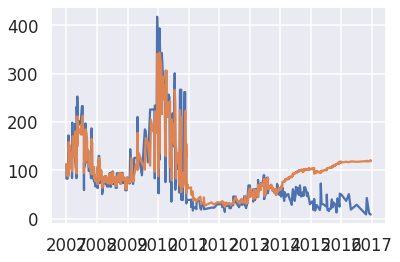

In [156]:
error = list_dataframe[3]
plt.plot(error['Date'], error['y'], label = "Real")
plt.plot(error['Date'], error['y_hat'], label = "Predicted")

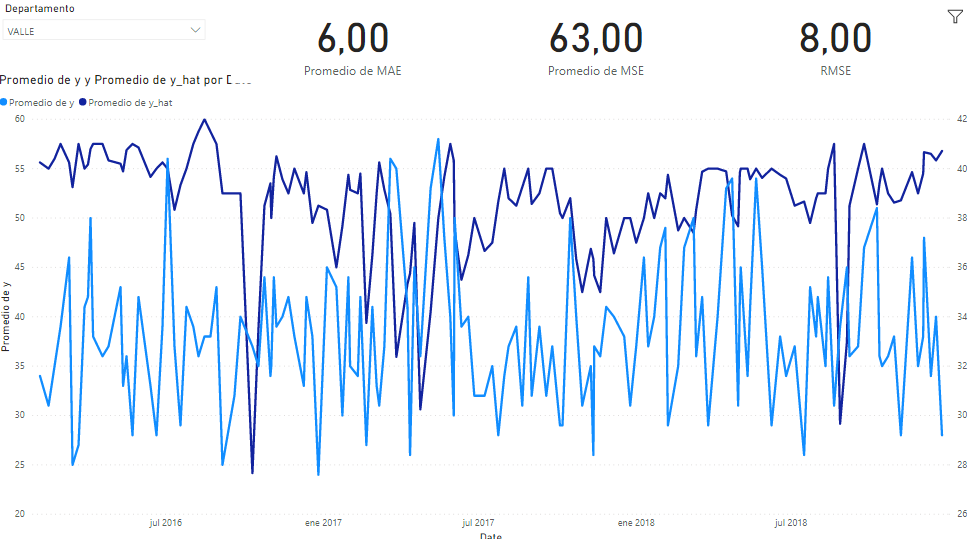

As we can see above, the same behavior occurs for the ARIMAX model, the model maintain reasonable values, but the RSME and MAE are much less if we compare it with the linear model, but it is a little tricky because it could be that the model is overgeneralized, if we analyze the trained model, we could see that the model are pretty equal to the real data but if we see the test data as we can see above, the model does not match with the real values, so,  ARIMAX does not prevent a method to prevent overgeneralization 

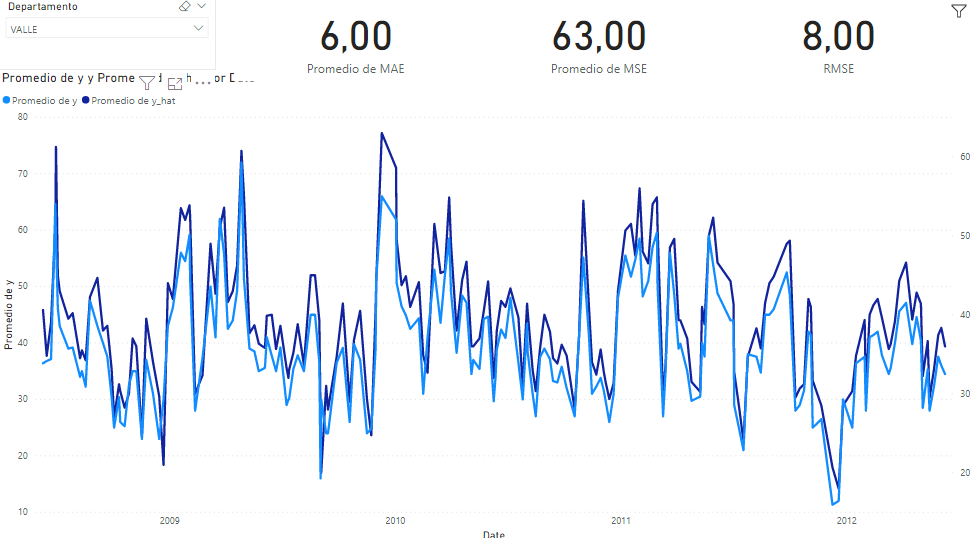

# LSTM

In [157]:
from math import sqrt
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop,Adam
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

In [158]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

ANTIOQUIA
(3511, 1, 27) (3511,) (1504, 1, 27) (1504,)
Epoch 1/50
49/49 - 3s - loss: 0.1509 - val_loss: 0.0764
Epoch 2/50
49/49 - 0s - loss: 0.1040 - val_loss: 0.0690
Epoch 3/50
49/49 - 0s - loss: 0.0989 - val_loss: 0.0659
Epoch 4/50
49/49 - 0s - loss: 0.0935 - val_loss: 0.0632
Epoch 5/50
49/49 - 0s - loss: 0.0884 - val_loss: 0.0614
Epoch 6/50
49/49 - 0s - loss: 0.0817 - val_loss: 0.0609
Epoch 7/50
49/49 - 0s - loss: 0.0740 - val_loss: 0.0578
Epoch 8/50
49/49 - 0s - loss: 0.0629 - val_loss: 0.0411
Epoch 9/50
49/49 - 0s - loss: 0.0486 - val_loss: 0.0312
Epoch 10/50
49/49 - 0s - loss: 0.0311 - val_loss: 0.0188
Epoch 11/50
49/49 - 0s - loss: 0.0227 - val_loss: 0.0166
Epoch 12/50
49/49 - 0s - loss: 0.0196 - val_loss: 0.0164
Epoch 13/50
49/49 - 0s - loss: 0.0192 - val_loss: 0.0156
Epoch 14/50
49/49 - 0s - loss: 0.0189 - val_loss: 0.0163
Epoch 15/50
49/49 - 0s - loss: 0.0195 - val_loss: 0.0161
Epoch 16/50
49/49 - 0s - loss: 0.0186 - val_loss: 0.0167
Epoch 17/50
49/49 - 0s - loss: 0.0186 - val

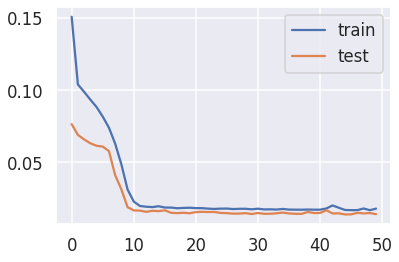

In [160]:
scaler = MinMaxScaler(feature_range=(0, 1))
model_name= 'LSTMS'
input = df_tuerculosis.copy()
list_dataframe = []
departamento = 'ANTIOQUIA'

print(departamento)
data = input[input['Departamento_residencia'] == departamento]
data = data.sort_values(by='Date')


list_variables = [
'FIXED_EDAD',
'Fixed_temp',
'Fixed_prep',
'Fixed_poverty',
'Fixed_indigence',
'SEXO_F',
'SEXO_M',
'TIP_SS_C',
'TIP_SS_E',
'TIP_SS_I',
'TIP_SS_N',
'TIP_SS_P',
'TIP_SS_S',
'count_cases']


x_var =  ['FIXED_EDAD',
'Fixed_temp',
'Fixed_prep',
'Fixed_poverty',
'Fixed_indigence',
'SEXO_F',
'SEXO_M',
'TIP_SS_C',
'TIP_SS_E',
'TIP_SS_I',
'TIP_SS_N',
'TIP_SS_P',
'TIP_SS_S']
y_var = ['count_cases']

data = data[list_variables]
values = data.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
reframed[['var1(t-1)',	'var2(t-1)',	'var3(t-1)',	'var4(t-1)'	,'var5(t-1)',\
          'var6(t-1)',	'var7(t-1)'	,'var8(t-1)',	'var9(t-1)',	'var10(t-1)',\
          'var11(t-1)',	'var12(t-1)',	'var13(t-1)',	'var14(t-1)','var14(t)']]
# split into train and test sets
values = reframed.values

size = data.shape[0]

train = values[:int(0.7*size), :]
test = values[int(0.7*size):, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [ ]:
a = reframed[['var1(t-1)',	'var2(t-1)',	'var3(t-1)',	'var4(t-1)'	,'var5(t-1)',	'var6(t-1)',	'var7(t-1)'	,'var8(t-1)',	'var9(t-1)',	'var10(t-1)',	'var11(t-1)',	'var12(t-1)',	'var13(t-1)',	'var14(t-1)','var14(t)']]
print(a.head())



# Forecast with Prophet

* Prophet is an open-source library developed by Facebook and designed for automatic forecasting of univariate time series data.


In [163]:
df_tuerculosis['Departamento_residencia'].unique()

array(['ANTIOQUIA', 'SANTANDER', 'ATLANTICO', 'EXTERIOR', 'BOLIVAR',
       'VALLE', 'BOGOTA', 'CUNDINAMARCA', 'TOLIMA', 'BOYACA', 'CALDAS',
       'CAUCA', 'CAQUETA', 'CESAR', 'HUILA', 'GUAJIRA', 'CHOCO',
       'NORTE SANTANDER', 'QUINDIO', 'CORDOBA', 'NARIÑO', 'MAGDALENA',
       'RISARALDA', 'AMAZONAS', 'SUCRE', 'META', 'ARAUCA', 'CASANARE',
       'SAN ANDRES', 'VAUPES', 'PUTUMAYO', 'VICHADA', 'GUAINIA',
       'PROCEDENCIA DESCONOCIDA', 'GUAVIARE'], dtype=object)

In [164]:
input = df_tuerculosis.copy()
departamento = 'ANTIOQUIA'

data = input[input['Departamento_residencia'] == departamento]
data = data[['Date','count_cases']].groupby('Date').mean().reset_index()
data = data.sort_values(by='Date')

In [165]:
data = data.rename(columns={'Date':'ds', 'count_cases': 'y'})
data = data.sort_values(by = 'ds')

In [166]:
size = data.shape[0]
train = data[:int(0.7*size)]
test = data[int(0.7*size):]
total = train.append(test)

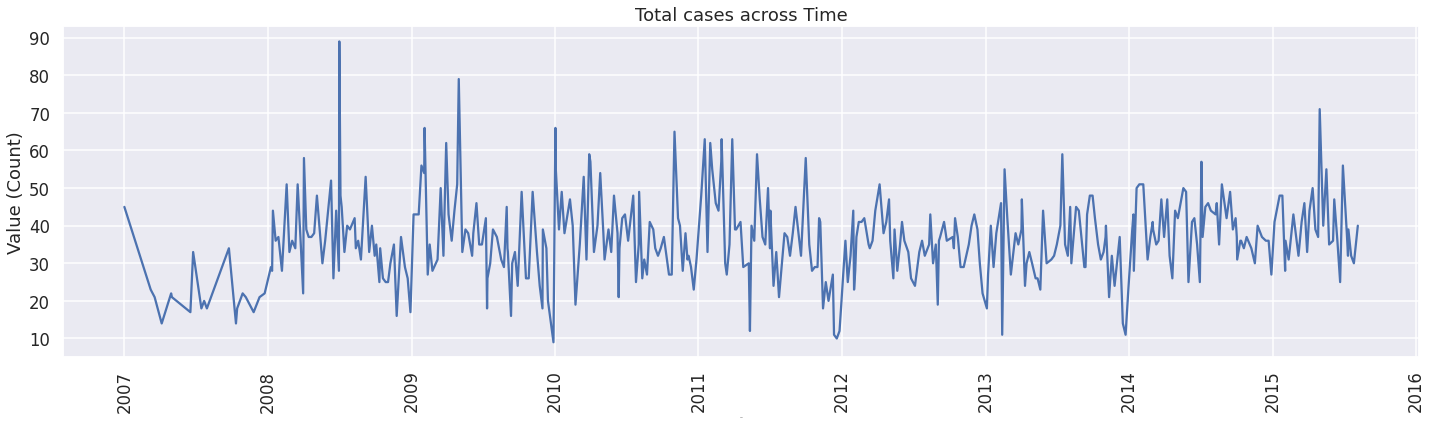

In [167]:
fig, ax1 = plt.subplots(figsize=(20,6))
ax = sns.lineplot(x='ds',y='y', data=train)

ax.set_title('Total cases across Time')
ax.set_ylabel('Value (Count)')
ax.set_xlabel('Time',fontsize=0.1)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show() 

In [168]:
# define the model
model = Prophet()
# fit the model
model.fit(train)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [169]:

future = total['ds'].copy().reset_index()
future = future[['ds']]
forecast = model.predict(future)
forecast = forecast.merge(total, on='ds', how='left')

In [170]:

y_true = data[int(0.7*size):]['y'].values
y_pred = forecast[int(0.7*size):]['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print('MAE: %.3f' % mae)
print('MSE: %.3f' % mse)
print('RMSE: %.3f' % np.sqrt(mse))


MAE: 6.706
MSE: 66.834
RMSE: 8.175


In [171]:
forecast['MAE'] = mae
forecast['MSE'] = mse
forecast['RMS'] = np.sqrt(mse)
forecast['Departamento'] = departamento
aux_1 = forecast[:int(0.7*size)].copy()
aux_1['aux_1'] = 0
aux_1['aux_2'] = 1
aux_2 = forecast[int(0.7*size):].copy()
aux_2['aux_1'] = 0
aux_2['aux_2'] = 1
forecast = aux_1.append(aux_2)


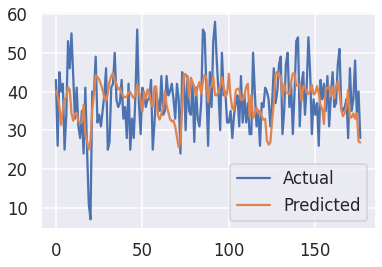

In [172]:
# plot expected vs actual
pyplot.plot(y_true, label='Actual')
pyplot.plot(y_pred, label='Predicted')
pyplot.legend()
pyplot.show()

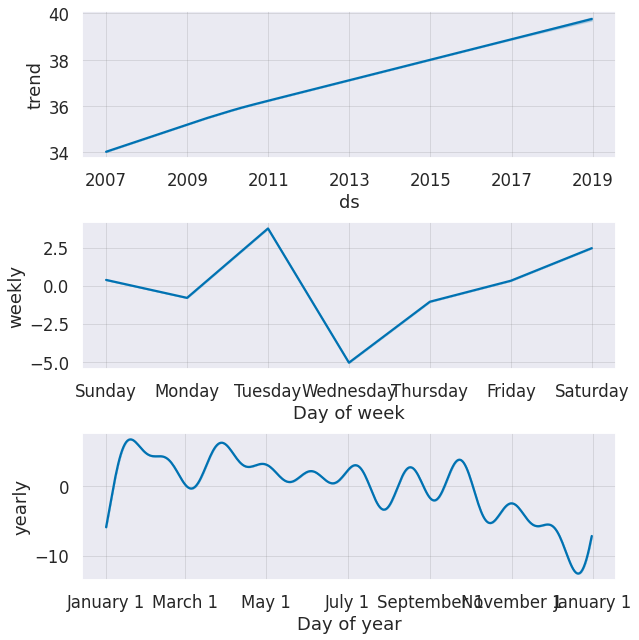

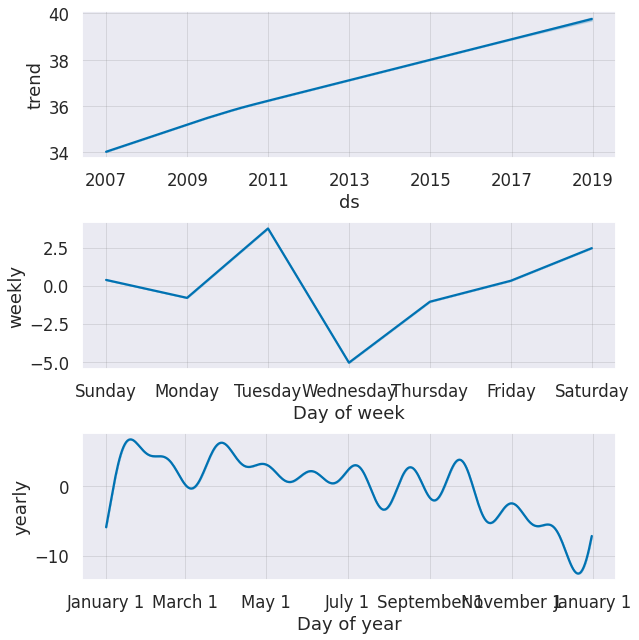

In [173]:
model.plot_components(forecast)



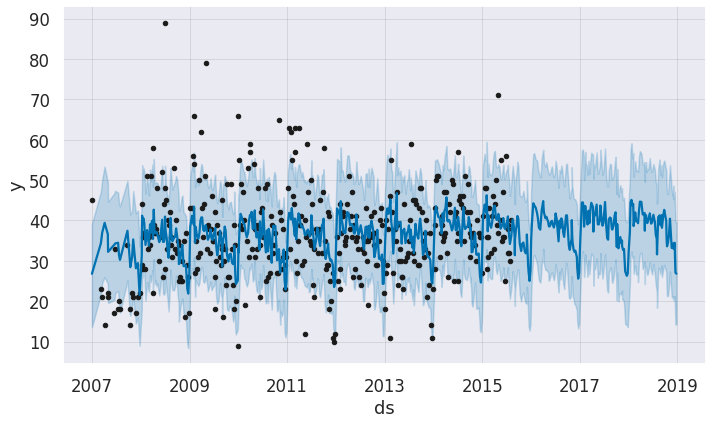

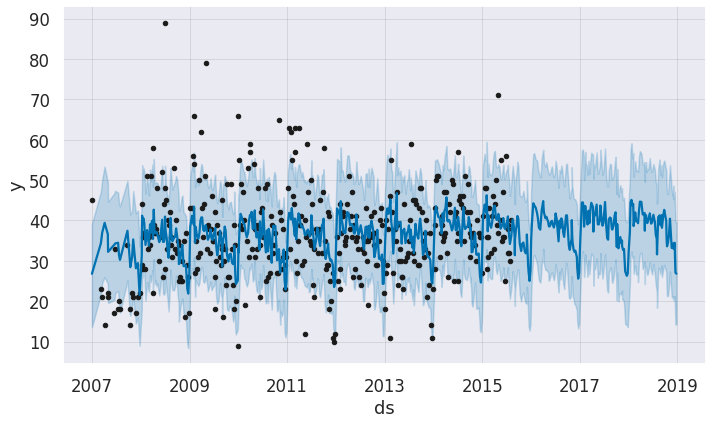

In [174]:
model.plot(forecast)


**Iterative Process**

In [185]:
def forecast(input_df, name_base):
  model_name= 'Forecast'
  input = input_df.copy()
  list_dataframe = []
  departamentos = list(input['Departamento_residencia'].unique())
  for departamento in departamentos:
    
    departamento = departamento
    print(departamento)
    data = input[input['Departamento_residencia'] == departamento]
    data = data[['Date','count_cases']].groupby('Date').mean().reset_index()
    data = data.sort_values(by='Date')
    data = data.rename(columns={'Date':'ds', 'count_cases': 'y'})
    data = data.sort_values(by = 'ds')

    size = data.shape[0]
    if  size < 10:
      continue
    train = data[:int(0.7*size)]
    test = data[int(0.7*size):]
    total = train.append(test)

    # define the model
    model = Prophet()
    # fit the model
    model.fit(train)
    path = 'data/Models/Forecast/' +name_base+"_"+\
     model_name +"_"+departamento+"_"+str(datetime.datetime.now())+"_"+'serialized_model.json'
    with open(path, 'w') as fout:
      json.dump(model_to_json(model), fout)  # Save model

    future = total['ds'].copy().reset_index()
    future = future[['ds']]
    forecast = model.predict(future)
    forecast = forecast.merge(total, on='ds', how='left')

    y_true = data[int(0.7*size):]['y'].values
    y_pred = forecast[int(0.7*size):]['yhat'].values
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    print('MAE: %.3f' % mae)
    print('MSE: %.3f' % mse)
    print('RMSE: %.3f' % np.sqrt(mse))

    forecast['MAE'] = mae
    forecast['MSE'] = mse
    forecast['RMS'] = np.sqrt(mse)
    forecast['Departamento'] = departamento
    aux_1 = forecast[:int(0.7*size)].copy()
    aux_1['aux_1'] = 0
    aux_1['aux_2'] = 1
    aux_2 = forecast[int(0.7*size):].copy()
    aux_2['aux_1'] = 0
    aux_2['aux_2'] = 1
    forecast = aux_1.append(aux_2)
    list_dataframe.append(forecast)
  return list_dataframe

In [186]:
list_dataframe = forecast(df_tuerculosis, "Tuberculosis")
forecast_df = pd.concat(list_dataframe)
forecast_df.to_csv('data/Models/forecast_Tuberculosis_df.csv')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ANTIOQUIA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 6.706
MSE: 66.834
RMSE: 8.175
SANTANDER


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 7.290
MSE: 81.219
RMSE: 9.012
ATLANTICO


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 18.


MAE: 6.530
MSE: 62.043
RMSE: 7.877
EXTERIOR


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 14.487
MSE: 354.296
RMSE: 18.823
BOLIVAR


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 6.618
MSE: 66.535
RMSE: 8.157
VALLE


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 6.804
MSE: 69.649
RMSE: 8.346
BOGOTA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 6.689
MSE: 66.189
RMSE: 8.136
CUNDINAMARCA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 6.636
MSE: 67.254
RMSE: 8.201
TOLIMA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 7.640
MSE: 87.529
RMSE: 9.356
BOYACA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 8.217
MSE: 112.929
RMSE: 10.627
CALDAS


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 7.459
MSE: 82.419
RMSE: 9.079
CAUCA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 7.482
MSE: 91.659
RMSE: 9.574
CAQUETA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 8.969
MSE: 117.398
RMSE: 10.835
CESAR


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 6.956
MSE: 73.704
RMSE: 8.585
HUILA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 6.919
MSE: 78.342
RMSE: 8.851
GUAJIRA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 7.069
MSE: 84.111
RMSE: 9.171
CHOCO


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 7.183
MSE: 77.919
RMSE: 8.827
NORTE SANTANDER


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 6.664
MSE: 76.764
RMSE: 8.762
QUINDIO


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 7.889
MSE: 98.872
RMSE: 9.943
CORDOBA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 7.293
MSE: 79.055
RMSE: 8.891
NARIÑO


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 9.742
MSE: 130.581
RMSE: 11.427
MAGDALENA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 8.268
MSE: 107.828
RMSE: 10.384
RISARALDA


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 6.363
MSE: 60.975
RMSE: 7.809
AMAZONAS


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 19.525
MSE: 668.051
RMSE: 25.847
SUCRE


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 11.579
MSE: 216.085
RMSE: 14.700
META


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 7.171
MSE: 77.291
RMSE: 8.792
ARAUCA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 10.183
MSE: 151.722
RMSE: 12.318
CASANARE


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 6.


MAE: 10.418
MSE: 158.931
RMSE: 12.607
SAN ANDRES


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


MAE: 341.572
MSE: 139130.391
RMSE: 373.002
VAUPES


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 613.163
MSE: 1009158.572
RMSE: 1004.569
PUTUMAYO


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


MAE: 6.842
MSE: 84.723
RMSE: 9.205
VICHADA


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 4.


MAE: 93.604
MSE: 16242.632
RMSE: 127.447
GUAINIA


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 11.


MAE: 145.442
MSE: 36590.938
RMSE: 191.288
PROCEDENCIA DESCONOCIDA
GUAVIARE
MAE: 227.586
MSE: 197943.666
RMSE: 444.909


In [187]:

list_dataframe = forecast(df_zika, "Zika")
forecast_df = pd.concat(list_dataframe)
forecast_df.to_csv('data/Models/forecast_df_Zika.csv')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ANTIOQUIA


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 663.253
MSE: 628654.371
RMSE: 792.877
CORDOBA


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 2049.119
MSE: 5135563.969
RMSE: 2266.178
SUCRE


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 4136.419
MSE: 21758810.636
RMSE: 4664.634
ATLANTICO


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 22.


MAE: 1459.023
MSE: 3259993.820
RMSE: 1805.545
CAUCA


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 1270.883
MSE: 2093484.108
RMSE: 1446.888
MAGDALENA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 2976.909
MSE: 12931428.043
RMSE: 3596.029
BOGOTA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 1101.323
MSE: 1631052.217
RMSE: 1277.127
CUNDINAMARCA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 2115.543
MSE: 7658606.877
RMSE: 2767.419
GUAINIA
VALLE


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 13.


MAE: 902.129
MSE: 1104777.120
RMSE: 1051.084
NARIÑO


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 5751.861
MSE: 56210090.408
RMSE: 7497.339
PROCEDENCIA DESCONOCIDA
ARAUCA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 2382.106
MSE: 9433710.895
RMSE: 3071.435
CASANARE


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 1696.083
MSE: 3928872.440
RMSE: 1982.138
META


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 2023.958
MSE: 5512304.544
RMSE: 2347.830
SANTANDER


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 1498.045
MSE: 2953778.993
RMSE: 1718.656
BOLIVAR


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 2675.974
MSE: 8320642.420
RMSE: 2884.552
HUILA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 655.255
MSE: 614177.790
RMSE: 783.695
TOLIMA


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 1435.924
MSE: 3079610.306
RMSE: 1754.882
BOYACA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 2579.505
MSE: 8449069.353
RMSE: 2906.728
NORTE SANTANDER


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 1168.431
MSE: 1934602.080
RMSE: 1390.900
RISARALDA


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 581.169
MSE: 791388.779
RMSE: 889.600
CAQUETA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 1168.465
MSE: 1867883.527
RMSE: 1366.705
PUTUMAYO


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 19.


MAE: 869.527
MSE: 1244490.850
RMSE: 1115.568
GUAVIARE


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 14.


MAE: 3965.505
MSE: 26781321.557
RMSE: 5175.067
EXTERIOR


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


MAE: 2124.765
MSE: 6230693.071
RMSE: 2496.136
GUAJIRA


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


MAE: 4892.747
MSE: 35987087.940
RMSE: 5998.924
QUINDIO


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


MAE: 3361.089
MSE: 22823107.609
RMSE: 4777.354
VICHADA


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


MAE: 4510.984
MSE: 41240051.090
RMSE: 6421.842
AMAZONAS


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 1259.422
MSE: 4312512.832
RMSE: 2076.659
CESAR


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


MAE: 1129.154
MSE: 2251652.722
RMSE: 1500.551
CHOCO


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 1129.670
MSE: 1837180.389
RMSE: 1355.426
CALDAS


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 1693.160
MSE: 3937405.032
RMSE: 1984.290
VAUPES
SAN ANDRES
MAE: 2908.538
MSE: 9927269.872
RMSE: 3150.757


In [188]:
list_dataframe = forecast(df_dengue, "Dengue")
forecast_df = pd.concat(list_dataframe)
forecast_df.to_csv('data/Models/forecast_df.csv')

ATLANTICO


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 27.941
MSE: 1108.315
RMSE: 33.291
BOGOTA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 46.701
MSE: 3326.197
RMSE: 57.673
BOYACA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 44.290
MSE: 3085.710
RMSE: 55.549
BOLIVAR


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 32.219
MSE: 1439.561
RMSE: 37.942
CAQUETA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 48.585
MSE: 3328.165
RMSE: 57.690
CAUCA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 79.842
MSE: 8366.516
RMSE: 91.469
HUILA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 69.567
MSE: 5506.099
RMSE: 74.203
CORDOBA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 67.151
MSE: 5355.692
RMSE: 73.183
META


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 65.146
MSE: 5144.187
RMSE: 71.723
CESAR


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 99.461
MSE: 10906.072
RMSE: 104.432
GUAJIRA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 50.022
MSE: 3203.549
RMSE: 56.600
ANTIOQUIA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 58.256
MSE: 3999.082
RMSE: 63.238
MAGDALENA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 59.567
MSE: 4640.361
RMSE: 68.120
EXTERIOR


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 466.009
MSE: 236600.671
RMSE: 486.416
CHOCO


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 100.795
MSE: 22333.660
RMSE: 149.445
CASANARE


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 106.563
MSE: 12225.285
RMSE: 110.568
NARIÑO


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 19.118
MSE: 588.637
RMSE: 24.262
NORTE SANTANDER


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 99.632
MSE: 11070.872
RMSE: 105.218
QUINDIO
MAE: 59.247
MSE: 5214.528
RMSE: 72.212
SANTANDER


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 100.769
MSE: 11505.266
RMSE: 107.263
CUNDINAMARCA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 64.371
MSE: 5121.512
RMSE: 71.565
VALLE


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 9.


MAE: 55.542
MSE: 3619.825
RMSE: 60.165
GUAINIA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 967.123
MSE: 1328209.115
RMSE: 1152.480
GUAVIARE


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 292.364
MSE: 95536.869
RMSE: 309.090
RISARALDA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 64.014
MSE: 5531.798
RMSE: 74.376
ARAUCA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 64.530
MSE: 5461.126
RMSE: 73.899
CALDAS


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 87.283
MSE: 11594.987
RMSE: 107.680
TOLIMA


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 46.615
MSE: 2657.121
RMSE: 51.547
SUCRE


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MAE: 28.731
MSE: 1179.466
RMSE: 34.343
PUTUMAYO


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 21.


MAE: 125.544
MSE: 17756.773
RMSE: 133.255
VICHADA


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 10.


MAE: 425.180
MSE: 442832.723
RMSE: 665.457
VAUPES
SAN ANDRES
AMAZONAS
MAE: 109.374
MSE: 33584.048
RMSE: 183.260


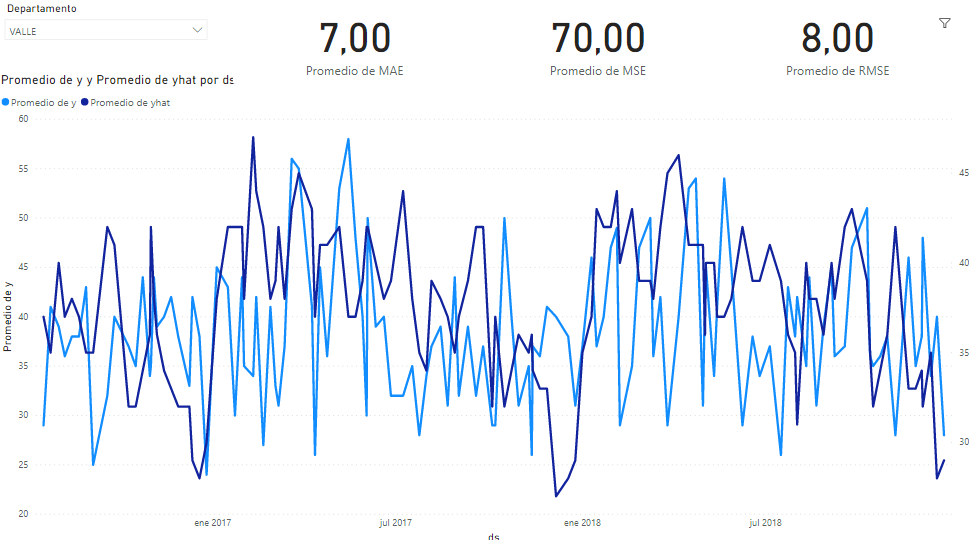

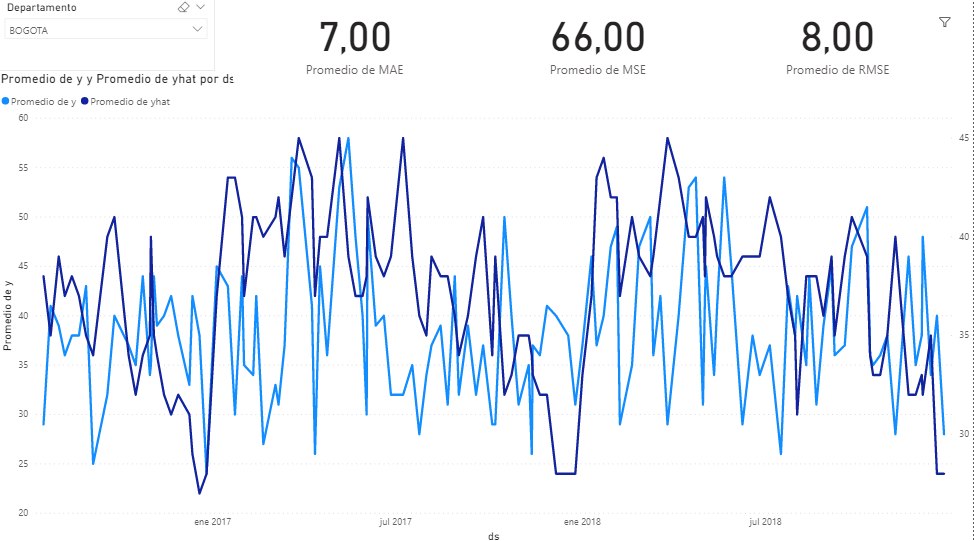

The above charts show us that the forecast model does not match very well with the real data, some times the predicted value has a behavior inverse proportional with the real data, but still the RMSE and MAE are small, but still insufficient to predict disease.

**Conclusions**



* Generating models that predict a disease as virulent as tuberculosis is a challenge in which it is necessary to work much more deeply, exogenous variables such as infection prevention programs or the analysis of spread vectors were not worked on in this study, for what the predictions of the models are not completely reliable to predict future values, in addition the independent variables (temperature, precipitation, indigence rate and poverty) do not effectively predict diseases, so we have to have other variables exogenous to help us improve the models.
* The imputation of variables can have direct consequences in the analysis models, however it was possible to implement an imputation that did not affect the original distribution of the data drastically, which helped to implement the model for all the departments of the country and analyze the behavior of the disease and its future prediction.

